# ``Taming Performance Variability''

### <font color='gray'> Analysis of benchmark order for various Wisconsin hardware/memory configurations</font>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks
import calendar

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/wisc-memtests"
# Save all dataframes and plots into this directory 
dest_dir = "output/wisc-memtests"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed. Use this flag throughout the notebook
verbose = True

# Include common helper functions. You can see the avilable files and their code 
# if you use JupyterHub's file browser to navigate to the specifed directory 
sys.path.append("bench-lib/")
from common import *

/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Stream -> X -> Stream Analysis
### <font color='gray'> Stream refers to a modified version of the Stream benchmark that runs both single-threaded and multi-threaded versions of the kernel in the same run, shows more comprehensive results and statistics, and saves the results in a CSV file.  Despite being a modified version of Stream, no modifications to the Stream kernels were made.  Stream runs 500 times over an array of 10 million doubles, either bound to the first socket via numactl or unbound.  This is repeated 200 times both before and after X, where X is either mctop or a 116 GB Spark sort on 8.2 billion persisted random numbers.</font>

In [2]:
# Import Stream -> X -> Stream results
stream_db = {}
for root, subs, files in os.walk(source_dir):
    for f in files:
        if ".csv" in f and "info" not in f:
            if f.split('.')[0] not in stream_db:
                stream_db[f.split('.')[0]] = pd.DataFrame()
            stream_db[f.split('.')[0]] = pd.concat([stream_db[f.split('.')[0]], pd.read_csv(os.path.join(root, f))])
            
if verbose:
    print "Keys: ", stream_db.keys()
    for k, df in stream_db.iteritems():
        print "Columns in %s:" % k, df.columns.tolist()
        display(df.sample(5))
        print "\n"

Keys:  ['stream-mctop-stream', 'stream-spark-stream', 'stream-mctop-stream-unbound', 'stream-spark-stream-unbound']
Columns in stream-mctop-stream: ['Unnamed: 0', 'copy_max', 'copy_min', 'copy_mean', 'copy_stdev', 'scale_max', 'scale_min', 'scale_mean', 'scale_stdev', 'add_max', 'add_min', 'add_mean', 'add_stdev', 'triad_max', 'triad_min', 'triad_mean', 'triad_stdev', 'copy_omp_max', 'copy_omp_min', 'copy_omp_mean', 'copy_omp_stdev', 'scale_omp_max', 'scale_omp_min', 'scale_omp_mean', 'scale_omp_stdev', 'add_omp_max', 'add_omp_min', 'add_omp_mean', 'add_omp_stdev', 'triad_omp_max', 'triad_omp_min', 'triad_omp_mean', 'triad_omp_stdev', 'omp_nthreads_used', 'units', 'timestamp', 'run_uuid', 'start_timestamp', 'nodeid', 'nodeuuid', 'socket_num', 'dvfs', 'run_num', 'hw_type', 'order']


,Unnamed: 0,copy_max,copy_min,copy_mean,copy_stdev,scale_max,scale_min,scale_mean,scale_stdev,add_max,...,timestamp,run_uuid,start_timestamp,nodeid,nodeuuid,socket_num,dvfs,run_num,hw_type,order
319,0,12453.55,9842.26,12419.82,121.36,12178.75,10102.20,12146.71,93.35,13907.03,...,1513730259,1752593d-4907-44b1-8e0e-e398ae26e8db,1513723532,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,0,yes,161,c220g1,before
228,0,12450.46,12098.88,12425.82,28.47,12168.24,11780.67,12135.44,27.47,13906.03,...,1513736430,1752593d-4907-44b1-8e0e-e398ae26e8db,1513723532,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,0,yes,104,c220g1,after
66,0,12490.81,9522.50,12457.48,141.46,12196.91,9343.62,12165.27,131.80,13940.20,...,1513732592,1752593d-4907-44b1-8e0e-e398ae26e8db,1513723532,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,0,yes,12,c220g1,after
17,0,12493.89,12080.08,12467.41,29.01,12178.56,11814.83,12152.62,27.81,13931.17,...,1513731722,1752593d-4907-44b1-8e0e-e398ae26e8db,1513723532,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,0,yes,196,c220g1,before
369,0,12320.11,11846.92,12293.66,33.50,12057.08,11733.55,12029.64,20.54,13768.45,...,1513740000,8670667c-9bb4-45dd-8d9a-936ea6d741f2,1513723529,c220g2-011302,19d00586-e8ec-11e5-a488-a3bb994732a6,0,yes,189,c220g2-bal,after




Columns in stream-spark-stream: ['Unnamed: 0', 'copy_max', 'copy_min', 'copy_mean', 'copy_stdev', 'scale_max', 'scale_min', 'scale_mean', 'scale_stdev', 'add_max', 'add_min', 'add_mean', 'add_stdev', 'triad_max', 'triad_min', 'triad_mean', 'triad_stdev', 'copy_omp_max', 'copy_omp_min', 'copy_omp_mean', 'copy_omp_stdev', 'scale_omp_max', 'scale_omp_min', 'scale_omp_mean', 'scale_omp_stdev', 'add_omp_max', 'add_omp_min', 'add_omp_mean', 'add_omp_stdev', 'triad_omp_max', 'triad_omp_min', 'triad_omp_mean', 'triad_omp_stdev', 'omp_nthreads_used', 'units', 'timestamp', 'run_uuid', 'start_timestamp', 'nodeid', 'nodeuuid', 'socket_num', 'dvfs', 'run_num', 'hw_type', 'order']


,Unnamed: 0,copy_max,copy_min,copy_mean,copy_stdev,scale_max,scale_min,scale_mean,scale_stdev,add_max,...,timestamp,run_uuid,start_timestamp,nodeid,nodeuuid,socket_num,dvfs,run_num,hw_type,order
339,0,11555.99,11153.38,11528.35,27.63,11325.60,11036.01,11302.80,22.61,12913.59,...,1515042099,cac129c2-f35f-4c77-8840-904b1ed2bc7f,1515022994,c220g2-011111,50de8e13-e8d4-11e5-a488-a3bb994732a6,0,yes,95,c220g2-unbal,after
69,0,12489.53,12158.73,12465.47,24.56,12178.65,11812.55,12151.50,27.23,13919.01,...,1515032656,c5d11941-921d-4608-857f-8549bcf640be,1515022994,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,0,yes,25,c220g1,after
50,0,10591.87,10337.07,10570.55,24.77,10270.81,10068.45,10255.32,17.24,11875.90,...,1515034559,cac129c2-f35f-4c77-8840-904b1ed2bc7f,1515022994,c220g2-011111,50de8e13-e8d4-11e5-a488-a3bb994732a6,0,yes,171,c220g2-unbal,before
394,0,11913.67,11548.86,11888.08,30.33,11671.23,11338.60,11644.18,19.66,13343.88,...,1515026574,181cee94-37b3-4d5a-b6e8-fed42a8e1e7e,1515022987,c220g2-011302,19d00586-e8ec-11e5-a488-a3bb994732a6,0,yes,86,c220g2-bal,before
313,0,12473.11,12101.49,12448.64,33.49,12138.73,11767.93,12111.38,28.49,13921.76,...,1515025460,c5d11941-921d-4608-857f-8549bcf640be,1515022994,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,0,yes,59,c220g1,before




Columns in stream-mctop-stream-unbound: ['Unnamed: 0', 'copy_max', 'copy_min', 'copy_mean', 'copy_stdev', 'scale_max', 'scale_min', 'scale_mean', 'scale_stdev', 'add_max', 'add_min', 'add_mean', 'add_stdev', 'triad_max', 'triad_min', 'triad_mean', 'triad_stdev', 'copy_omp_max', 'copy_omp_min', 'copy_omp_mean', 'copy_omp_stdev', 'scale_omp_max', 'scale_omp_min', 'scale_omp_mean', 'scale_omp_stdev', 'add_omp_max', 'add_omp_min', 'add_omp_mean', 'add_omp_stdev', 'triad_omp_max', 'triad_omp_min', 'triad_omp_mean', 'triad_omp_stdev', 'omp_nthreads_used', 'units', 'timestamp', 'run_uuid', 'start_timestamp', 'nodeid', 'nodeuuid', 'socket_num', 'dvfs', 'run_num', 'hw_type', 'order']


,Unnamed: 0,copy_max,copy_min,copy_mean,copy_stdev,scale_max,scale_min,scale_mean,scale_stdev,add_max,...,timestamp,run_uuid,start_timestamp,nodeid,nodeuuid,socket_num,dvfs,run_num,hw_type,order
276,0,11135.67,10724.89,11101.76,40.67,10910.10,10507.83,10883.59,36.02,12464.97,...,1513778890,575d0a01-531a-497d-8502-9a92c8dd6a97,1513758621,c220g2-011111,50de8e13-e8d4-11e5-a488-a3bb994732a6,both,yes,188,c220g2-unbal,after
179,0,11177.53,8821.11,11133.31,148.64,10899.22,9637.74,10864.11,65.47,12500.39,...,1513762272,051daba7-cf67-4d9b-97f2-b874785fac03,1513758613,c220g2-011302,19d00586-e8ec-11e5-a488-a3bb994732a6,both,yes,90,c220g2-bal,before
370,0,11685.06,9059.11,11635.31,140.60,11510.15,8909.25,11456.03,163.69,13084.22,...,1513761667,958685eb-364f-4917-9129-d7f7a4ae1300,1513758635,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,both,yes,76,c220g1,before
204,0,11117.62,9658.84,11089.21,73.63,10935.24,10505.54,10901.85,37.39,12343.09,...,1513766809,575d0a01-531a-497d-8502-9a92c8dd6a97,1513758621,c220g2-011111,50de8e13-e8d4-11e5-a488-a3bb994732a6,both,yes,138,c220g2-unbal,before
52,0,11513.76,9361.10,11366.89,100.81,11252.61,9228.34,11161.74,110.76,12945.31,...,1513763144,958685eb-364f-4917-9129-d7f7a4ae1300,1513758635,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,both,yes,113,c220g1,before




Columns in stream-spark-stream-unbound: ['Unnamed: 0', 'copy_max', 'copy_min', 'copy_mean', 'copy_stdev', 'scale_max', 'scale_min', 'scale_mean', 'scale_stdev', 'add_max', 'add_min', 'add_mean', 'add_stdev', 'triad_max', 'triad_min', 'triad_mean', 'triad_stdev', 'copy_omp_max', 'copy_omp_min', 'copy_omp_mean', 'copy_omp_stdev', 'scale_omp_max', 'scale_omp_min', 'scale_omp_mean', 'scale_omp_stdev', 'add_omp_max', 'add_omp_min', 'add_omp_mean', 'add_omp_stdev', 'triad_omp_max', 'triad_omp_min', 'triad_omp_mean', 'triad_omp_stdev', 'omp_nthreads_used', 'units', 'timestamp', 'run_uuid', 'start_timestamp', 'nodeid', 'nodeuuid', 'socket_num', 'dvfs', 'run_num', 'hw_type', 'order']


,Unnamed: 0,copy_max,copy_min,copy_mean,copy_stdev,scale_max,scale_min,scale_mean,scale_stdev,add_max,...,timestamp,run_uuid,start_timestamp,nodeid,nodeuuid,socket_num,dvfs,run_num,hw_type,order
283,0,11571.02,11109.11,11493.89,67.98,11343.14,9740.04,11258.49,94.61,13024.56,...,1515099764,4b2db590-785c-4456-b72e-6c74980a8fe3,1515095882,c220g1-030803,fbae02d5-2931-11e6-8934-779211246dcb,both,yes,97,c220g1,before
390,0,11075.74,8709.88,11020.38,133.26,10875.41,8875.93,10824.22,123.34,12393.94,...,1515111489,b7c66cce-68f0-43e0-af95-07bc86740da0,1515095866,c220g2-011302,19d00586-e8ec-11e5-a488-a3bb994732a6,both,yes,178,c220g2-bal,after
338,0,11202.81,8783.52,11124.82,147.67,10883.23,9857.55,10815.13,77.21,12490.09,...,1515107907,b7c66cce-68f0-43e0-af95-07bc86740da0,1515095866,c220g2-011302,19d00586-e8ec-11e5-a488-a3bb994732a6,both,yes,90,c220g2-bal,after
279,0,11015.48,9708.55,10985.00,67.37,10791.65,9384.88,10760.42,69.03,12369.96,...,1515109533,b7c66cce-68f0-43e0-af95-07bc86740da0,1515095866,c220g2-011302,19d00586-e8ec-11e5-a488-a3bb994732a6,both,yes,130,c220g2-bal,after
212,0,11150.22,9390.60,11119.87,82.65,11126.82,10004.22,11096.32,71.42,12469.24,...,1515110789,4a562771-7b50-473a-a69e-3f8b76afcab7,1515095877,c220g2-011111,50de8e13-e8d4-11e5-a488-a3bb994732a6,both,yes,57,c220g2-unbal,after


In [3]:
# Specify order list here to make plots plot in the right order
orders = ["before", "after"]

# Print mean stats
for config in stream_db.keys():
    print config
    for order in orders:
        print "\t" + order + ":"
        for (hw_type), conf in stream_db[config][stream_db[config]["order"] == order].groupby("hw_type"):
            print "\t\t" + hw_type + " mean of means: " + str(conf["add_omp_mean"].mean())
            print "\t\t" + hw_type + " stdev of means: " + str(conf["add_omp_mean"].std())
            print "\t\t" + hw_type + " mean of stdevs: " + str(np.sqrt((conf["add_omp_stdev"]**2).mean())) + "\n"

stream-mctop-stream
	before:
		c220g1 mean of means: 36427.91645
		c220g1 stdev of means: 141.258030731
		c220g1 mean of stdevs: 51.2822779233

		c220g2-bal mean of means: 42010.5821
		c220g2-bal stdev of means: 226.101730447
		c220g2-bal mean of stdevs: 104.724953564

		c220g2-unbal mean of means: 12967.5667
		c220g2-unbal stdev of means: 390.918651459
		c220g2-unbal mean of stdevs: 24.1142090789

	after:
		c220g1 mean of means: 36475.2793
		c220g1 stdev of means: 132.782898606
		c220g1 mean of stdevs: 46.8085627743

		c220g2-bal mean of means: 41972.5747
		c220g2-bal stdev of means: 245.574748816
		c220g2-bal mean of stdevs: 109.403531767

		c220g2-unbal mean of means: 38583.33445
		c220g2-unbal stdev of means: 1029.721207
		c220g2-unbal mean of stdevs: 108.065788182

stream-spark-stream
	before:
		c220g1 mean of means: 36482.77335
		c220g1 stdev of means: 111.151873932
		c220g1 mean of stdevs: 139.367156357

		c220g2-bal mean of means: 41641.5501
		c220g2-bal stdev of means: 234.724

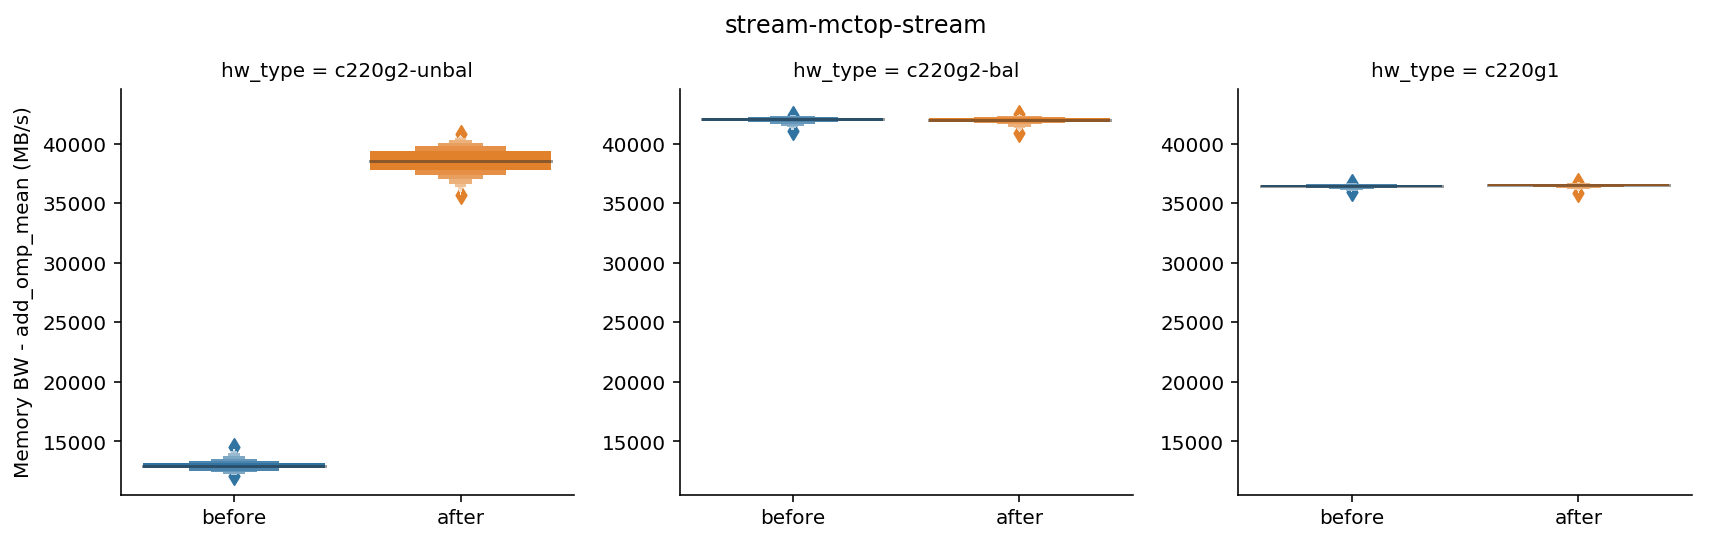

/notebooks/output/wisc-memtests/stream-mctop-stream-lvplot.pdf

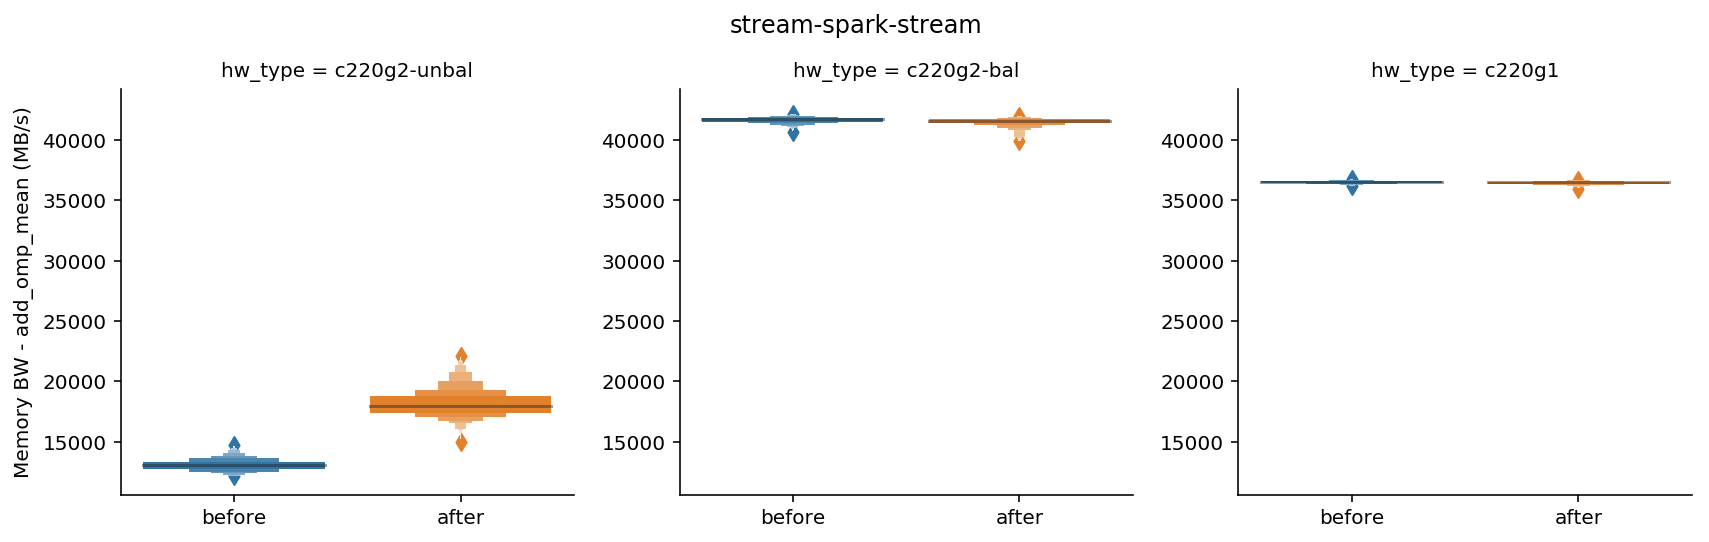

/notebooks/output/wisc-memtests/stream-spark-stream-lvplot.pdf

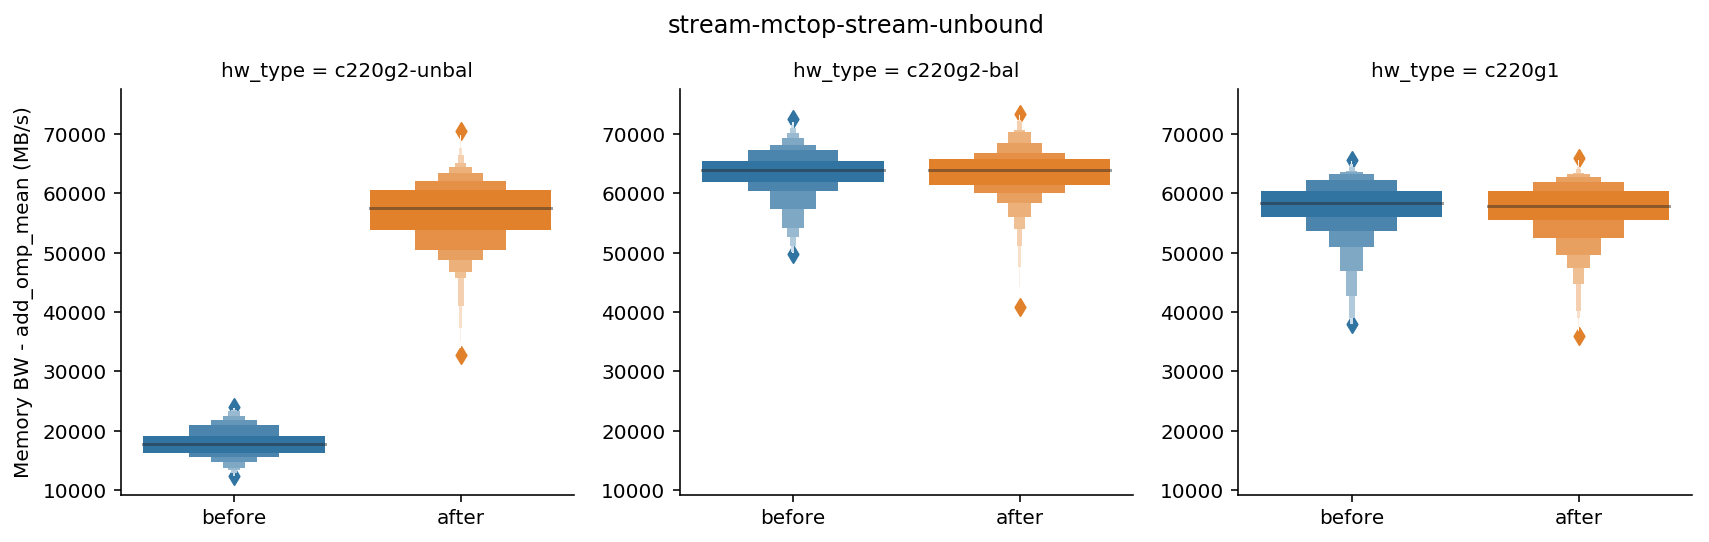

/notebooks/output/wisc-memtests/stream-mctop-stream-unbound-lvplot.pdf

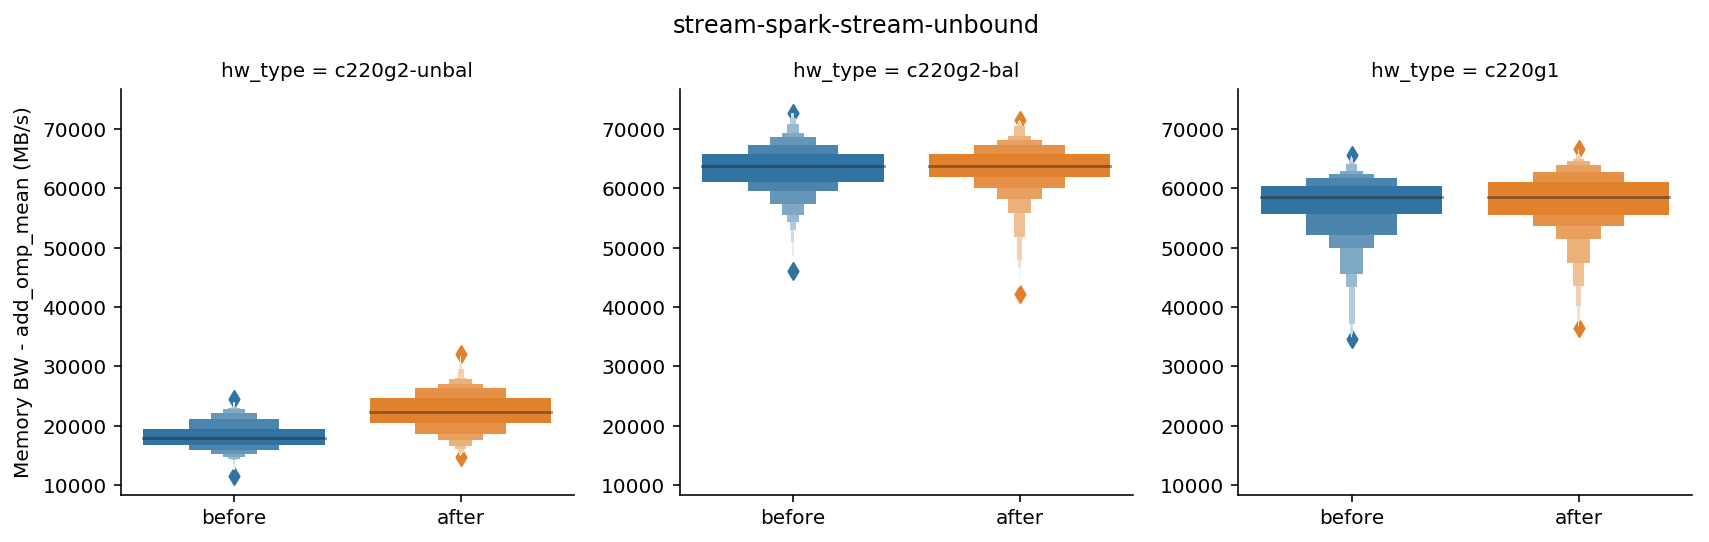

/notebooks/output/wisc-memtests/stream-spark-stream-unbound-lvplot.pdf

In [4]:
# LV Plots
test = "add_omp_mean"
for config in stream_db.keys():
    sns_plot = sns.factorplot(x="order", y=test, col="hw_type", order=orders, kind="lv", data=stream_db[config])
    sns_plot.set_axis_labels("", "Memory BW - " + test + " (MB/s)")
    sns_plot.fig.suptitle(config)
    sns_plot.fig.subplots_adjust(top=.85)
    dest = config + "-lvplot.pdf"
    plot_show_and_save(sns_plot.fig, dest, dest_dir)

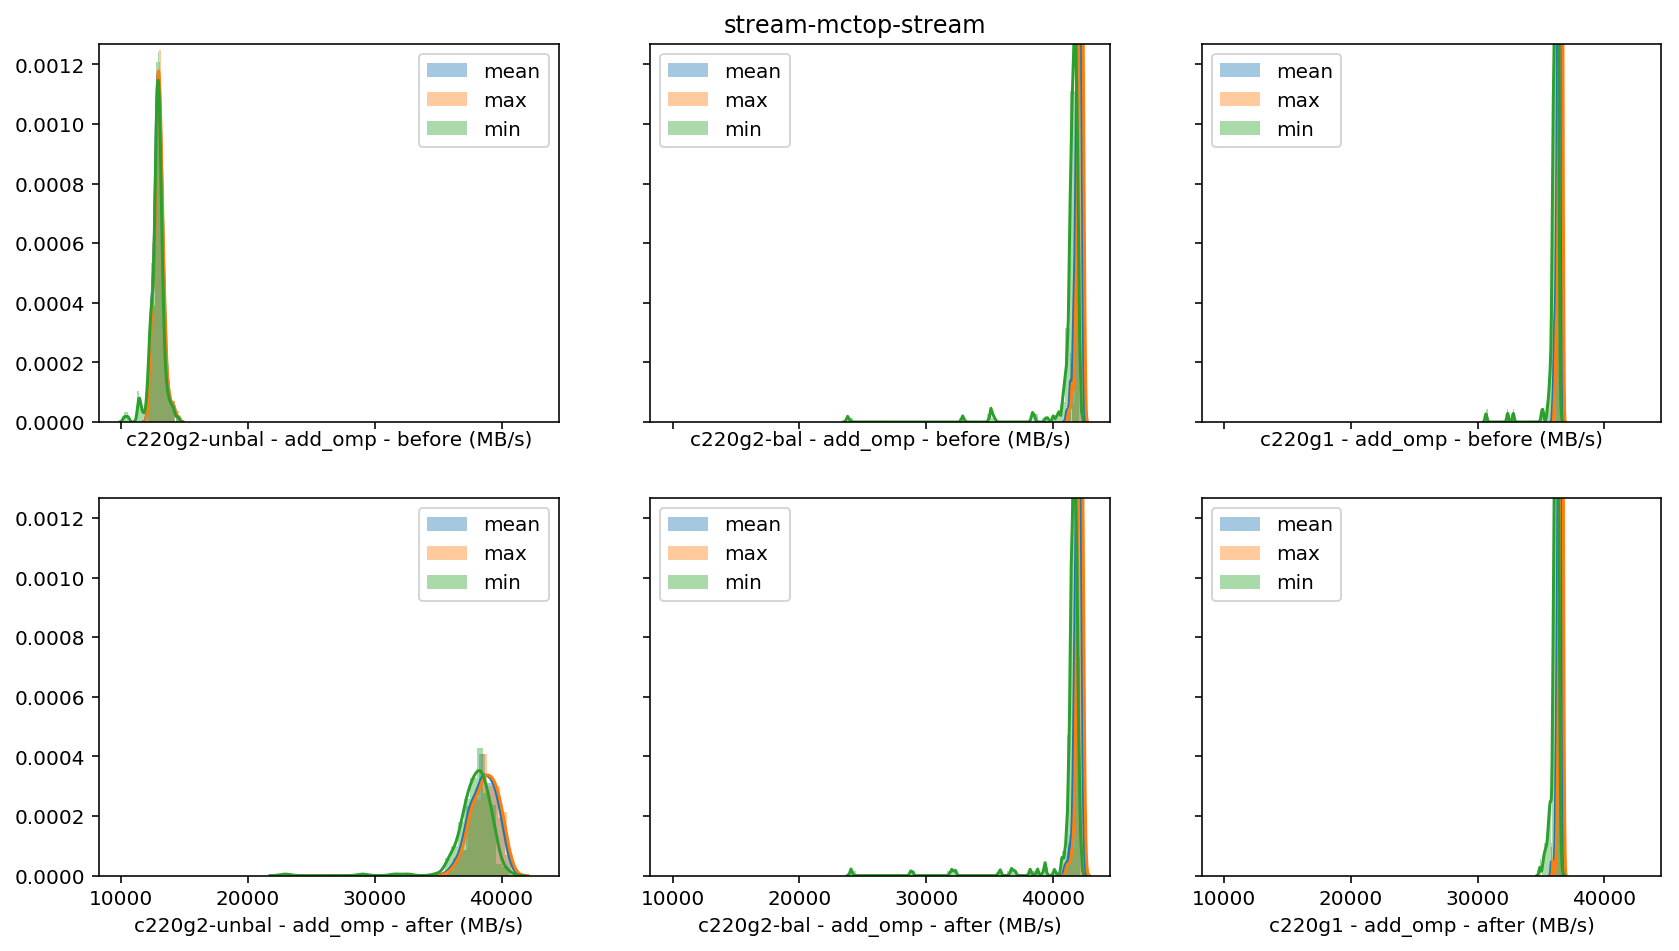

/notebooks/output/wisc-memtests/stream-mctop-stream-histograms.pdf

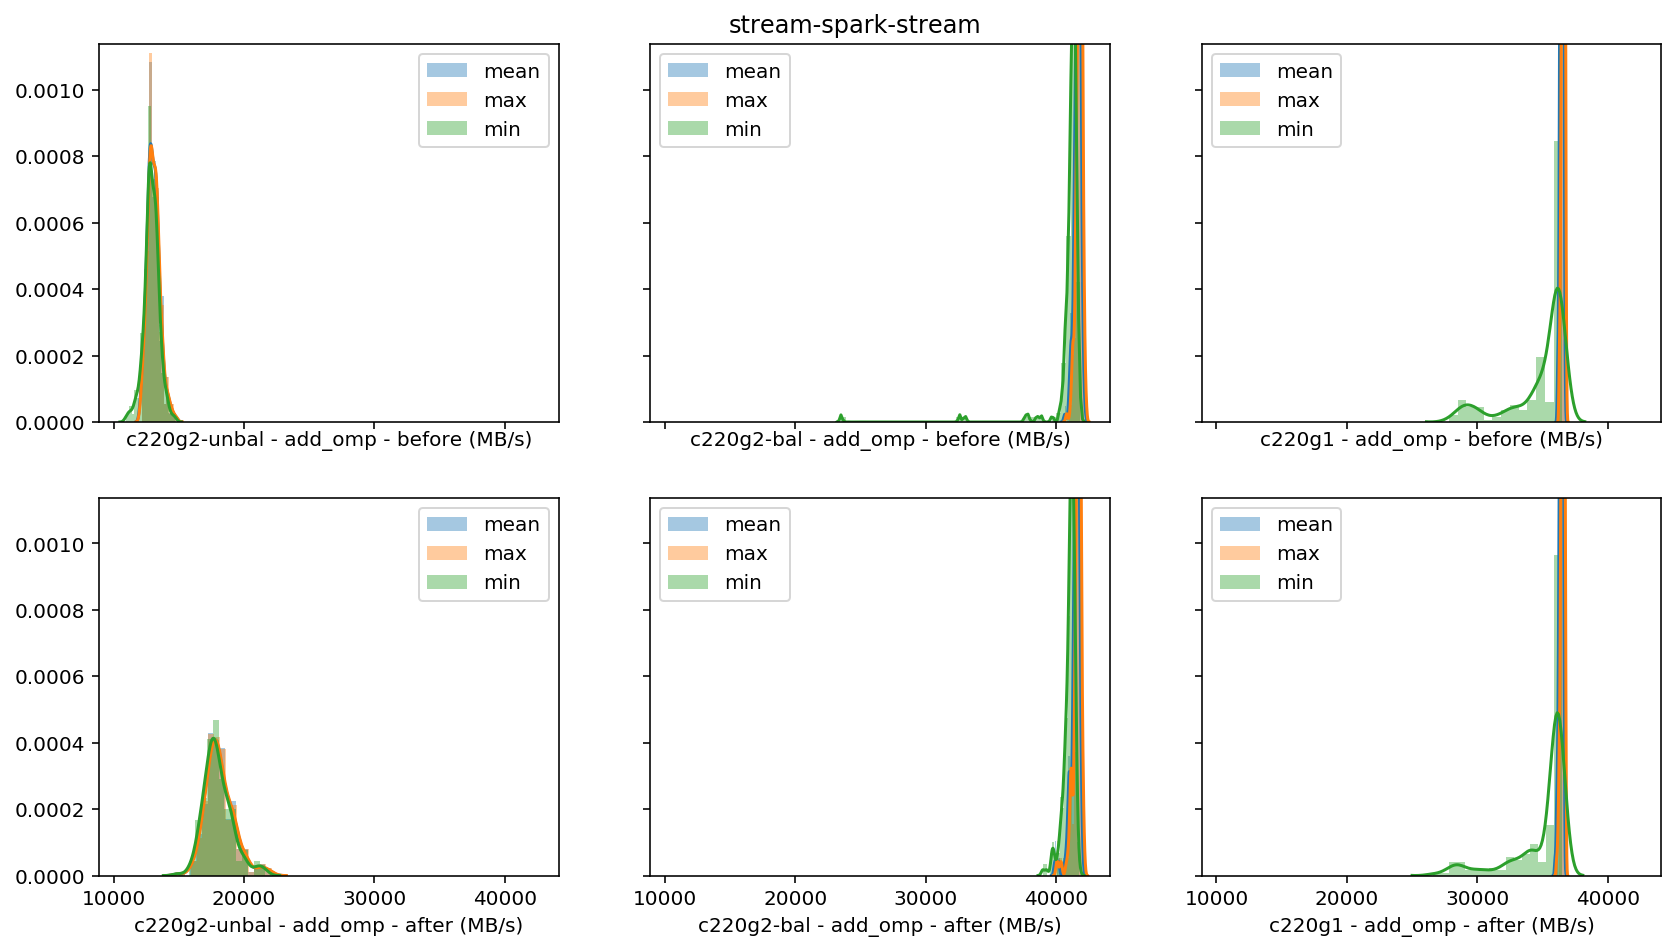

/notebooks/output/wisc-memtests/stream-spark-stream-histograms.pdf

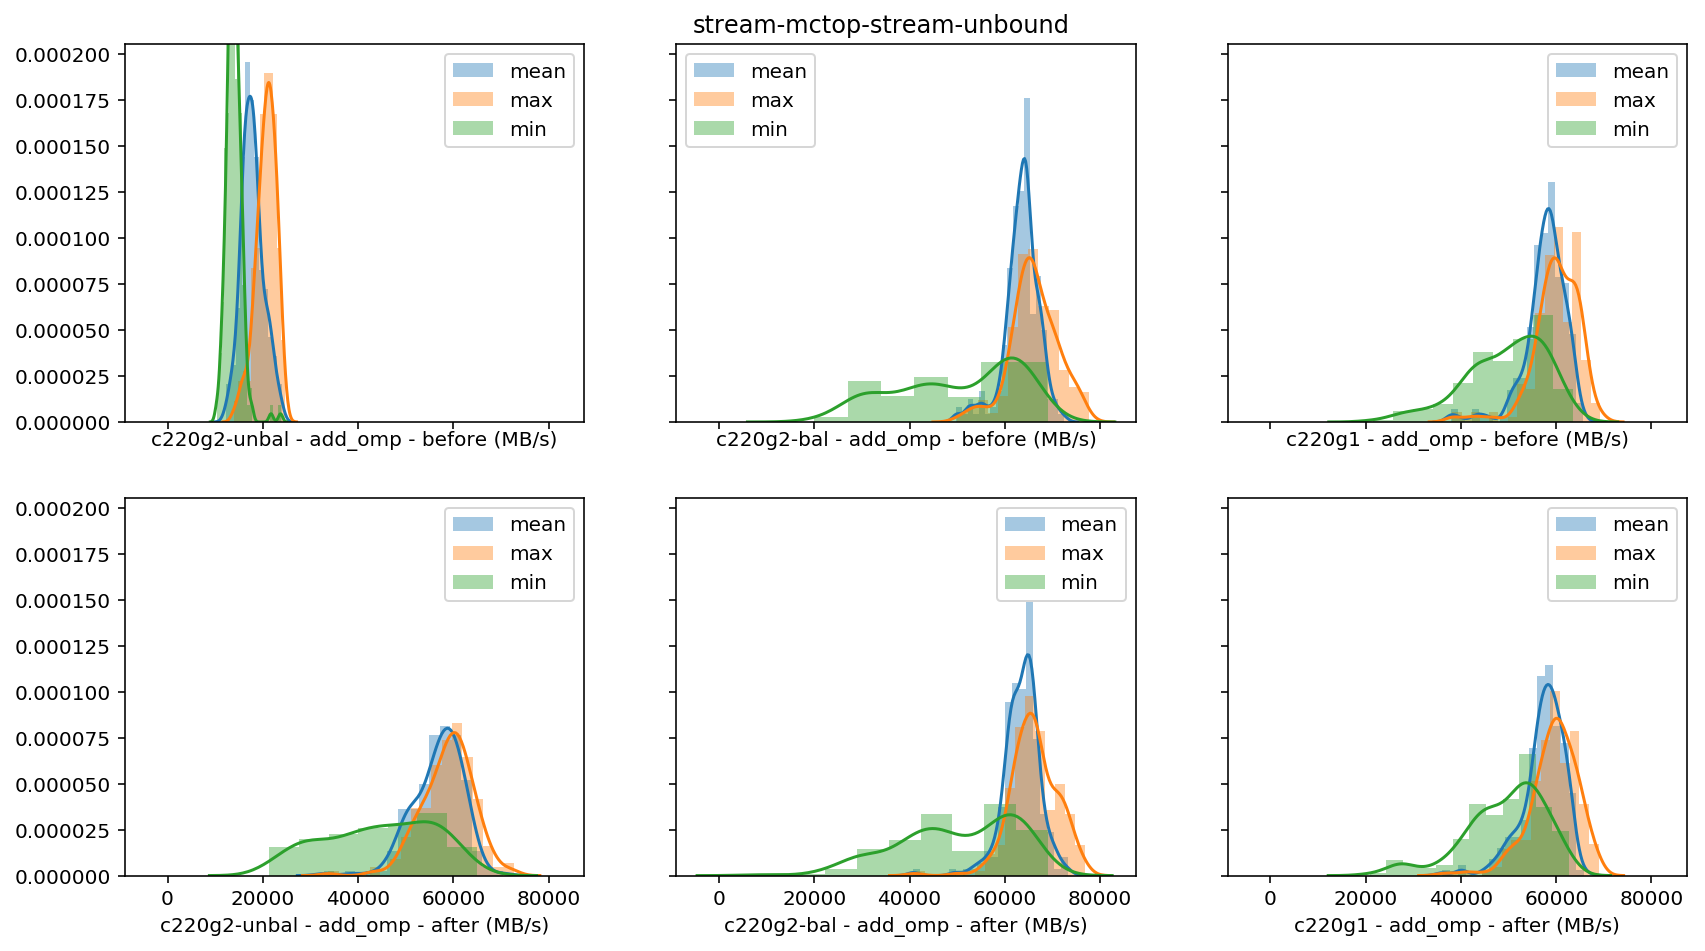

/notebooks/output/wisc-memtests/stream-mctop-stream-unbound-histograms.pdf

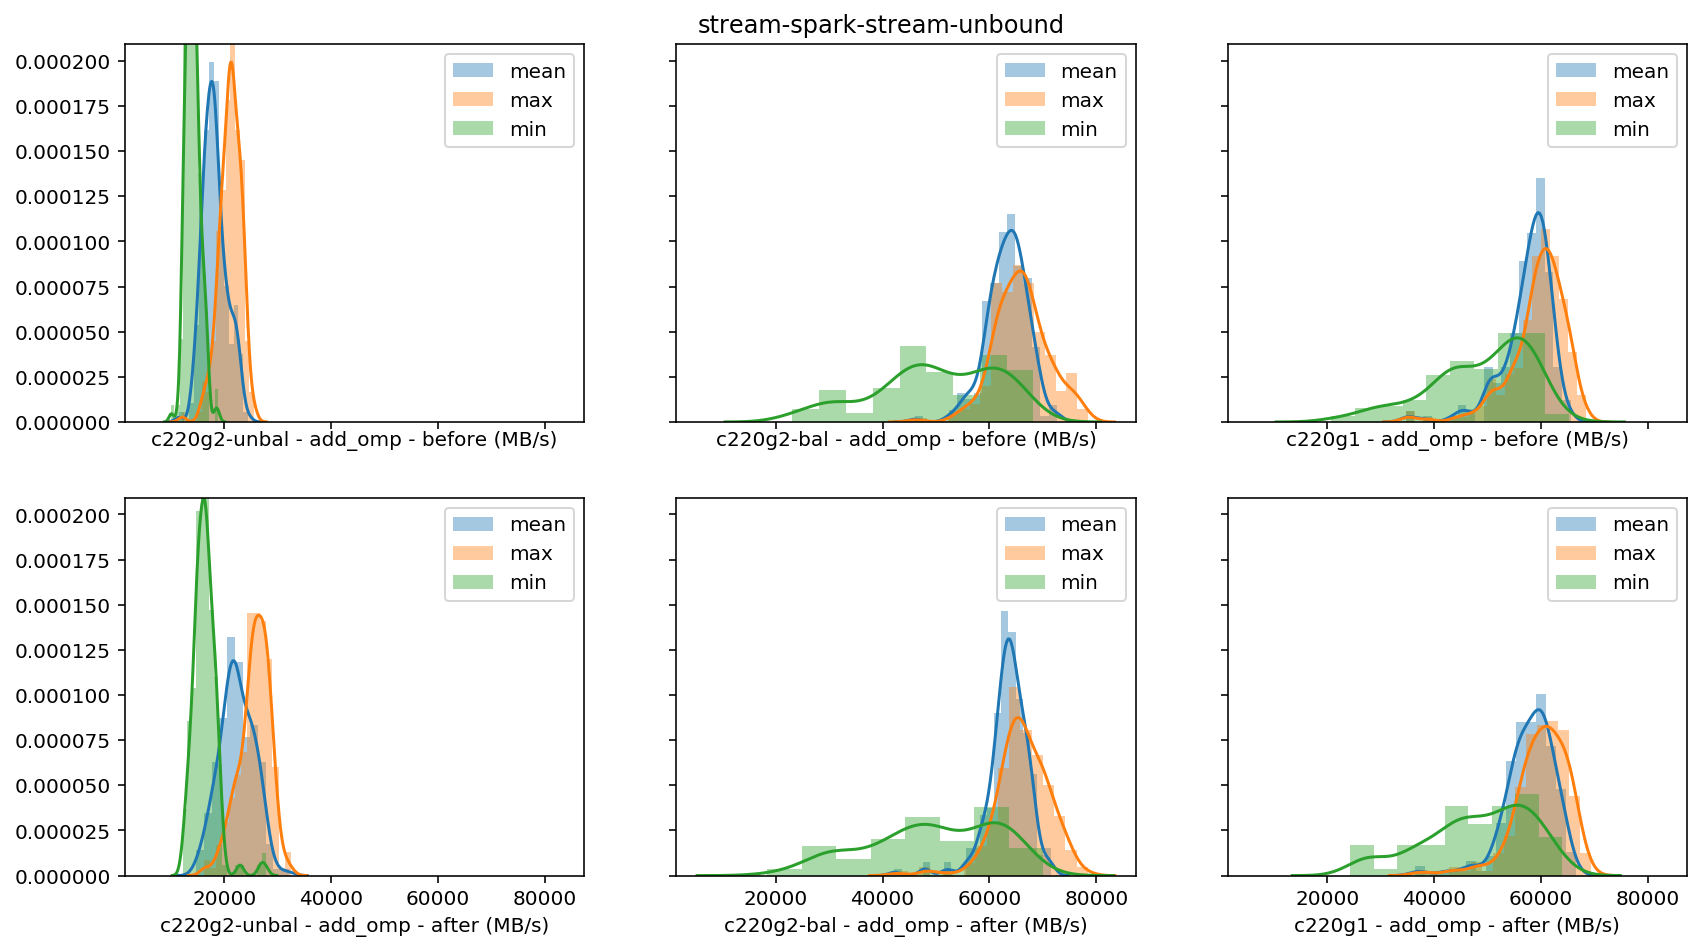

/notebooks/output/wisc-memtests/stream-spark-stream-unbound-histograms.pdf

In [5]:
# Min, Mean, and Max Histograms
test = "add_omp"
for config in stream_db.keys():
    max_hw_types = len(stream_db[config]["hw_type"].unique())
    max_orders = len(stream_db[config]["order"].unique())
    f, axarr = plt.subplots(max_orders, max_hw_types, sharex=True, sharey=True, figsize=(14, 7))
    for order_idx, order in enumerate(orders):
        for hw_type_idx, hw_type in enumerate(stream_db[config]["hw_type"].unique()):
            plot_df = subset_df(stream_db[config], {"hw_type": hw_type, "order": order})
            sns.distplot(plot_df[test + "_mean"], ax=axarr[order_idx, hw_type_idx], label="mean")
            sns.distplot(plot_df[test + "_max"], ax=axarr[order_idx, hw_type_idx], label="max")
            sns.distplot(plot_df[test + "_min"], ax=axarr[order_idx, hw_type_idx], label="min")
            axarr[order_idx, hw_type_idx].set(xlabel=hw_type + ' - ' + test + ' - ' + order + ' (MB/s)')
            axarr[order_idx, hw_type_idx].legend()
    f.suptitle(config)
    f.subplots_adjust(top=.95)
    dest = config + "-histograms.pdf"
    plot_show_and_save(f, dest, dest_dir)

## Spark-> X -> Spark Analysis
### <font color='gray'> Spark refers to a 2 GB Spark sort on 250 million persisted random numbers. This is repeated 200 times both before and after X, where X is either mctop or a 116 GB Spark sort on 8.2 billion persisted random numbers.</font>

In [6]:
# Import Spark -> X -> Spark results
spark_db = {}
for hw_type in os.listdir(source_dir):
    hw_type_path = os.path.join(source_dir, hw_type)
    for bench in os.listdir(hw_type_path):
        if 'stream' not in bench and 'Store' not in bench:        
            bench_path = os.path.join(hw_type_path, bench)
            for f in os.listdir(bench_path):
                if '.out' in f and 'bigspark' not in f:
                    order = f.split('_')[0]
                    if bench not in spark_db:
                        spark_db[bench] = pd.DataFrame()
                        spark_db[bench + '-unbound'] = pd.DataFrame()
                    results_list = open(os.path.join(bench_path, f)).read().splitlines()
                    results_tuple = [(float(x),hw_type,order) for x in results_list]
                    results_df = pd.DataFrame.from_records(results_tuple, columns = ['time', 'hw_type', 'order'])
                    #print results_df
                    if 'unbound' in f:
                        spark_db[bench + '-unbound'] = pd.concat([spark_db[bench + '-unbound'], results_df])
                    else:
                        spark_db[bench] = pd.concat([spark_db[bench], results_df])
if verbose:
    print "Keys: ", spark_db.keys()
    for k, df in spark_db.iteritems():
        print "Columns in %s:" % k, df.columns.tolist()
        display(df.sample(5))
        print "\n"


Keys:  ['spark-mctop-spark', 'spark-bigspark-spark', 'spark-mctop-spark-unbound', 'spark-bigspark-spark-unbound']
Columns in spark-mctop-spark: ['time', 'hw_type', 'order']


,time,hw_type,order
92,1.669742,c220g1,before
133,1.289102,c220g2-bal,after
139,1.306507,c220g2-bal,before
120,1.552226,c220g1,after
60,1.513433,c220g2-unbal,after




Columns in spark-bigspark-spark: ['time', 'hw_type', 'order']


,time,hw_type,order
176,1.315399,c220g2-bal,after
71,1.661074,c220g1,after
90,1.282559,c220g2-bal,after
13,1.632583,c220g1,after
49,1.316207,c220g2-bal,after




Columns in spark-mctop-spark-unbound: ['time', 'hw_type', 'order']


,time,hw_type,order
154,1.303353,c220g1,after
79,1.251437,c220g1,after
72,1.237388,c220g2-unbal,after
169,1.590045,c220g2-unbal,before
90,1.311904,c220g1,before




Columns in spark-bigspark-spark-unbound: ['time', 'hw_type', 'order']


,time,hw_type,order
53,1.298377,c220g1,after
37,1.229229,c220g1,after
33,1.262480,c220g2-bal,after
179,1.614535,c220g2-unbal,before
108,1.384974,c220g1,after


In [7]:
# Specify order list here to make plots plot in the right order
orders = ["before", "after"]

# Print mean stats
for config in spark_db.keys():
    print config
    for order in orders:
        print "\t" + order + ":"
        for (hw_type), conf in spark_db[config][spark_db[config]["order"] == order].groupby("hw_type"):
            print "\t\t" + hw_type + " mean: " + str(conf["time"].mean())
            print "\t\t" + hw_type + " stdev: " + str(conf["time"].std())    

spark-mctop-spark
	before:
		c220g1 mean: 1.62260021925
		c220g1 stdev: 0.0503451261568
		c220g2-bal mean: 1.32355832577
		c220g2-bal stdev: 0.0535058356607
		c220g2-unbal mean: 2.00758331895
		c220g2-unbal stdev: 0.0467460800473
	after:
		c220g1 mean: 1.61920457959
		c220g1 stdev: 0.0479008977314
		c220g2-bal mean: 1.32369712234
		c220g2-bal stdev: 0.0463862060523
		c220g2-unbal mean: 1.46313773513
		c220g2-unbal stdev: 0.0437075720557
spark-bigspark-spark
	before:
		c220g1 mean: 1.62618783474
		c220g1 stdev: 0.0514712356201
		c220g2-bal mean: 1.33039102435
		c220g2-bal stdev: 0.0492536835404
		c220g2-unbal mean: 2.00770234227
		c220g2-unbal stdev: 0.0524262489154
	after:
		c220g1 mean: 1.62006655216
		c220g1 stdev: 0.0500966799234
		c220g2-bal mean: 1.32560282946
		c220g2-bal stdev: 0.046570538214
		c220g2-unbal mean: 1.50401665926
		c220g2-unbal stdev: 0.0381814780556
spark-mctop-spark-unbound
	before:
		c220g1 mean: 1.31336948276
		c220g1 stdev: 0.0552552211203
		c220g2-bal mean: 1

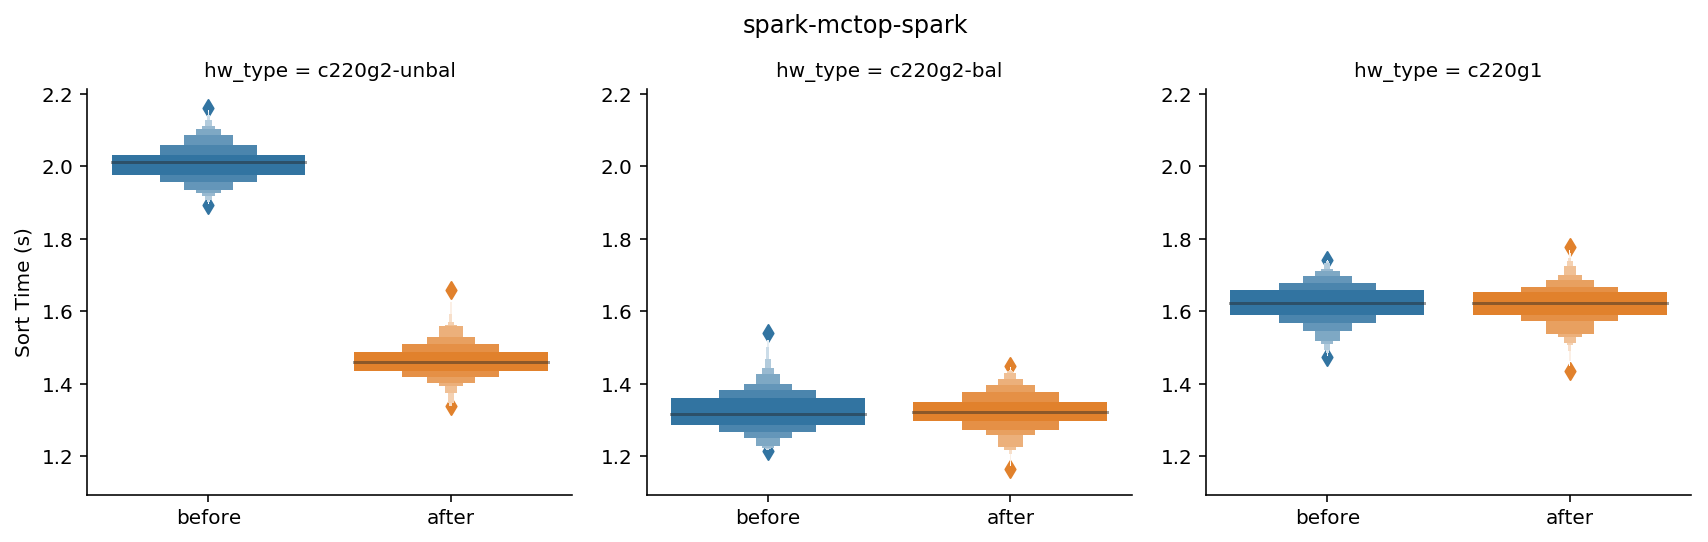

/notebooks/output/wisc-memtests/spark-mctop-spark-lvplot.pdf

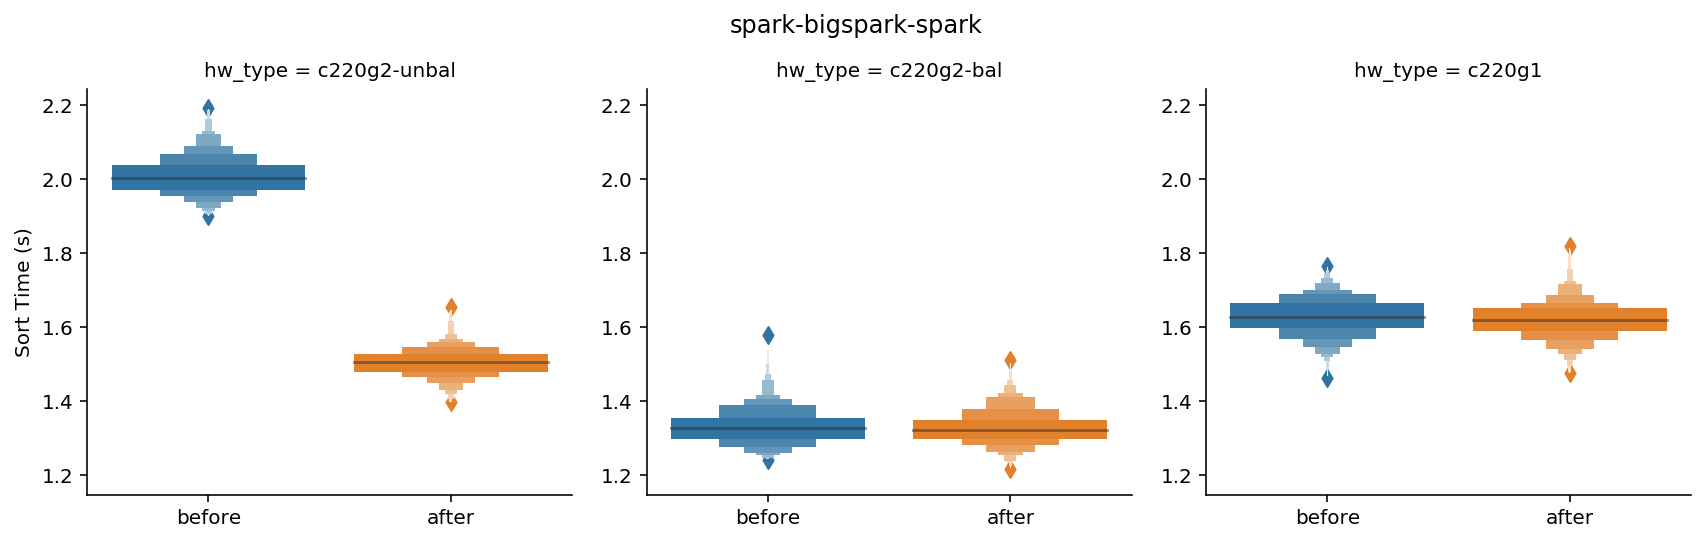

/notebooks/output/wisc-memtests/spark-bigspark-spark-lvplot.pdf

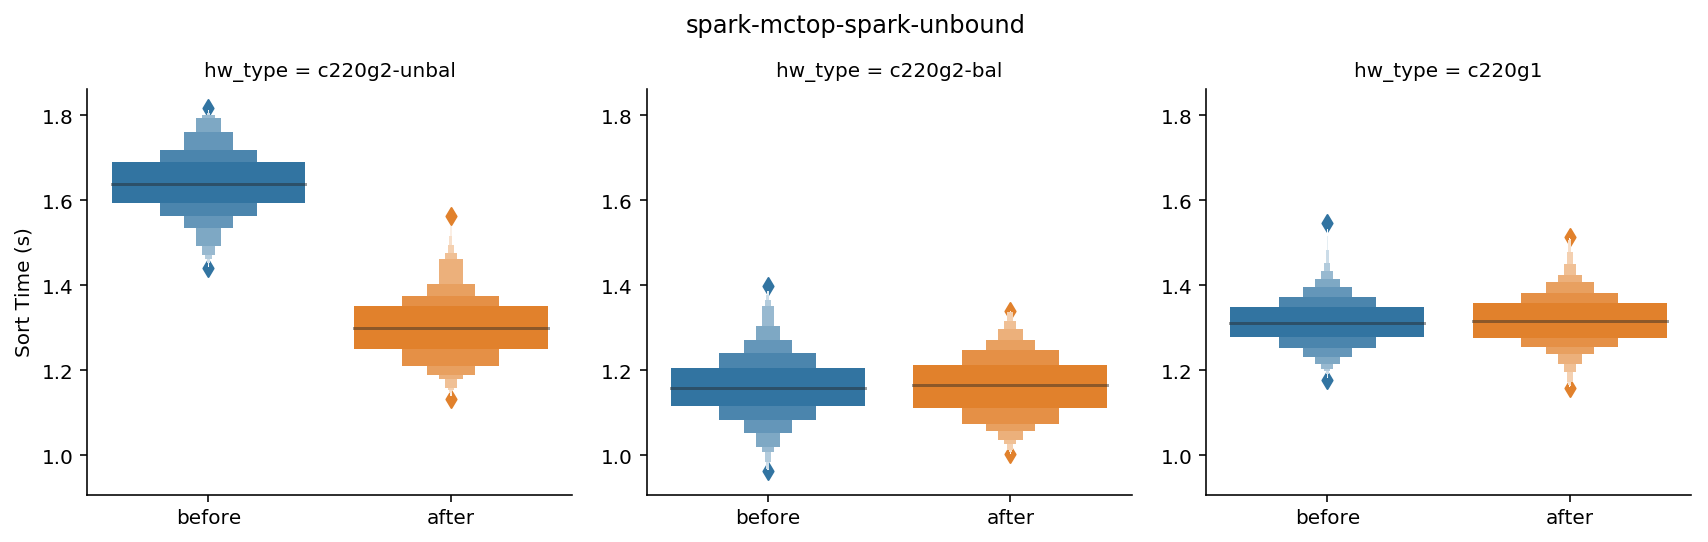

/notebooks/output/wisc-memtests/spark-mctop-spark-unbound-lvplot.pdf

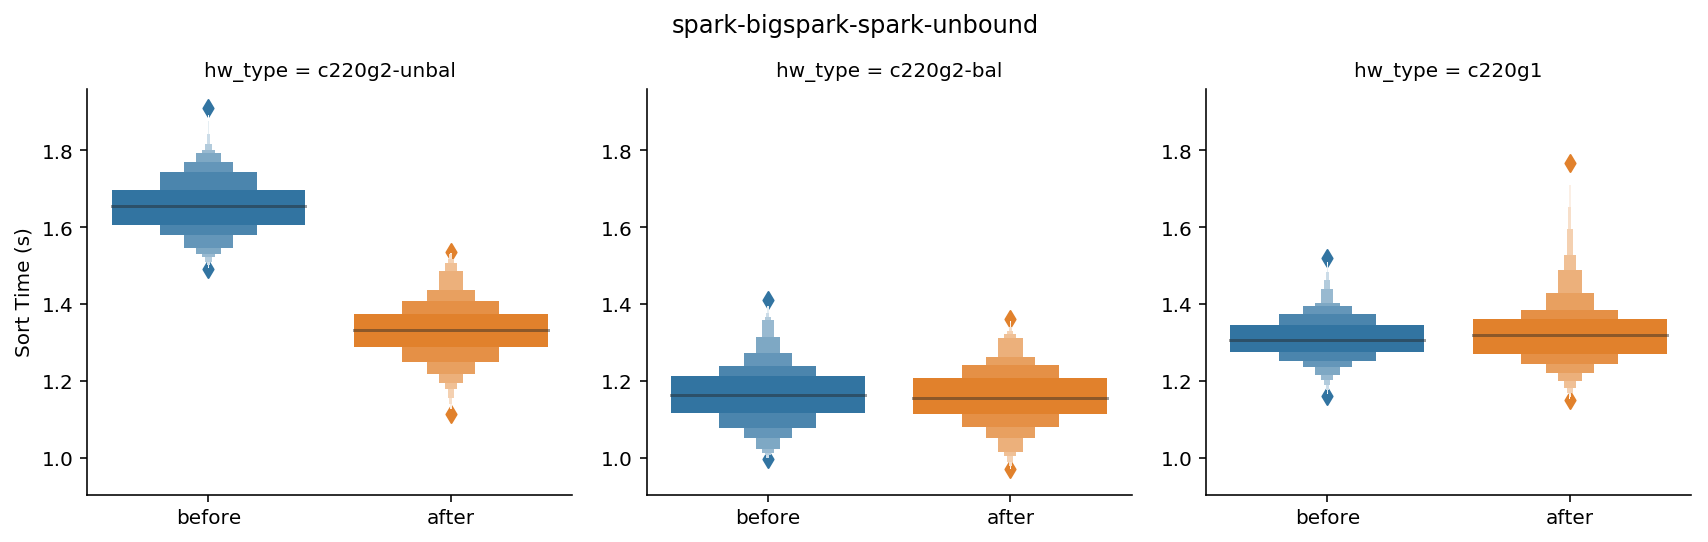

/notebooks/output/wisc-memtests/spark-bigspark-spark-unbound-lvplot.pdf

In [8]:
# LV Plots
for config in spark_db.keys():
    sns_plot = sns.factorplot(x="order", y="time", col="hw_type", order=orders, kind="lv", data=spark_db[config])
    sns_plot.set_axis_labels("", "Sort Time (s)")
    sns_plot.fig.suptitle(config)
    sns_plot.fig.subplots_adjust(top=.85)
    dest = config + "-lvplot.pdf"
    plot_show_and_save(sns_plot.fig, dest, dest_dir)

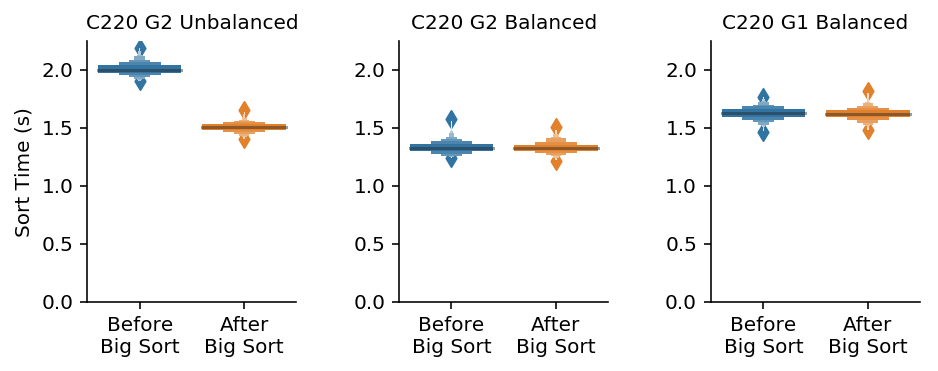

/notebooks/output/wisc-memtests/spark-bigspark-spark-lvplot-submission.pdf

Unbalanced Before G2 median 2.00073099136
Unbalanced After G2 median 1.50598502159
Ratio 0.752717395837


In [9]:
# LV Plots - reworked slightly for inclusion in paper.
config = 'spark-bigspark-spark'
df = spark_db['spark-bigspark-spark'].replace(
    ['c220g2-unbal', 'c220g2-bal', 'c220g1'],
    ['C220 G2 Unbalanced', 'C220 G2 Balanced', 'C220 G1 Balanced'])
df = df.replace(['before', 'after'],
                ['Before\nBig Sort', 'After\nBig Sort'])
sns_plot = sns.factorplot(y="time", x="order", col="hw_type", order=['Before\nBig Sort', 'After\nBig Sort'], kind="lv", data=df,
                          sharex=True, sharey=True, size=3, aspect=0.75)#, margin_titles=True)
sns_plot.set_titles("{col_name}") # Can't get margin_titles to work with set_titles cause life
sns_plot.set_axis_labels("", "Sort Time (s)")
sns_plot.fig.subplots_adjust(top=.85)
axes = sns_plot.axes
axes[0,1].set_ylim(0,)
axes[0,1].set_ylim(0,)
dest = config + "-lvplot-submission.pdf"
plot_show_and_save(sns_plot.fig, dest, dest_dir)

g2Before = float(df[(df['hw_type'] == 'C220 G2 Unbalanced') & (df['order'] == 'Before\nBig Sort')].median())
g2After = float(df[(df['hw_type'] == 'C220 G2 Unbalanced') & (df['order'] == 'After\nBig Sort')].median())

print 'Unbalanced Before G2 median', g2Before
print 'Unbalanced After G2 median', g2After
print 'Ratio', g2After/g2Before

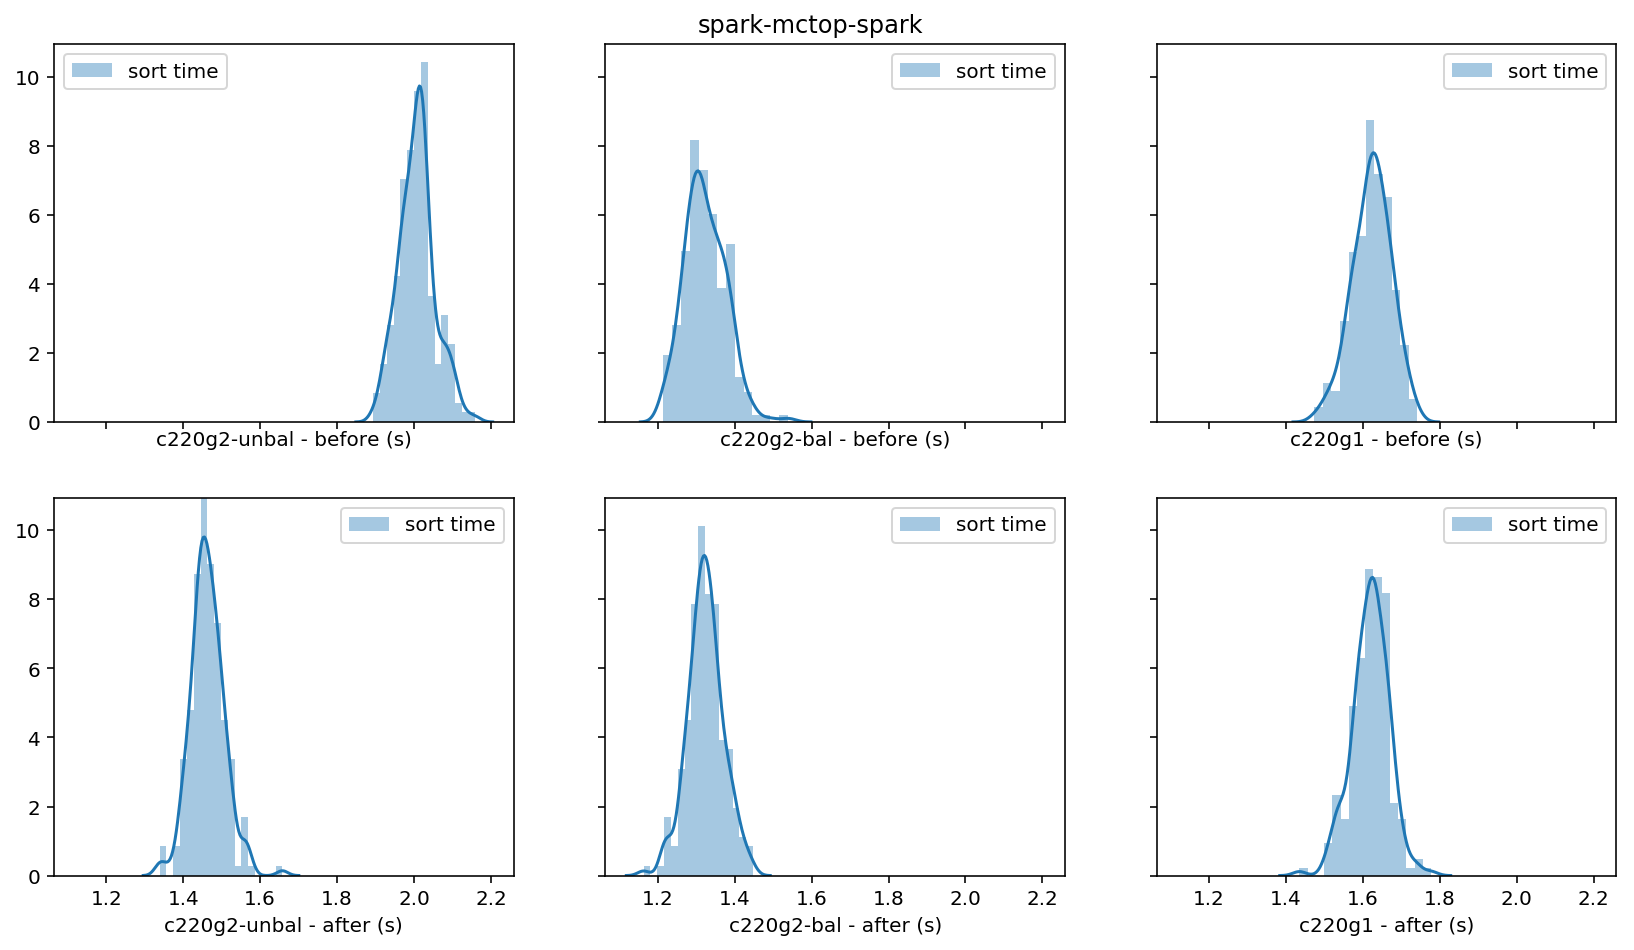

/notebooks/output/wisc-memtests/spark-mctop-spark-histograms.pdf

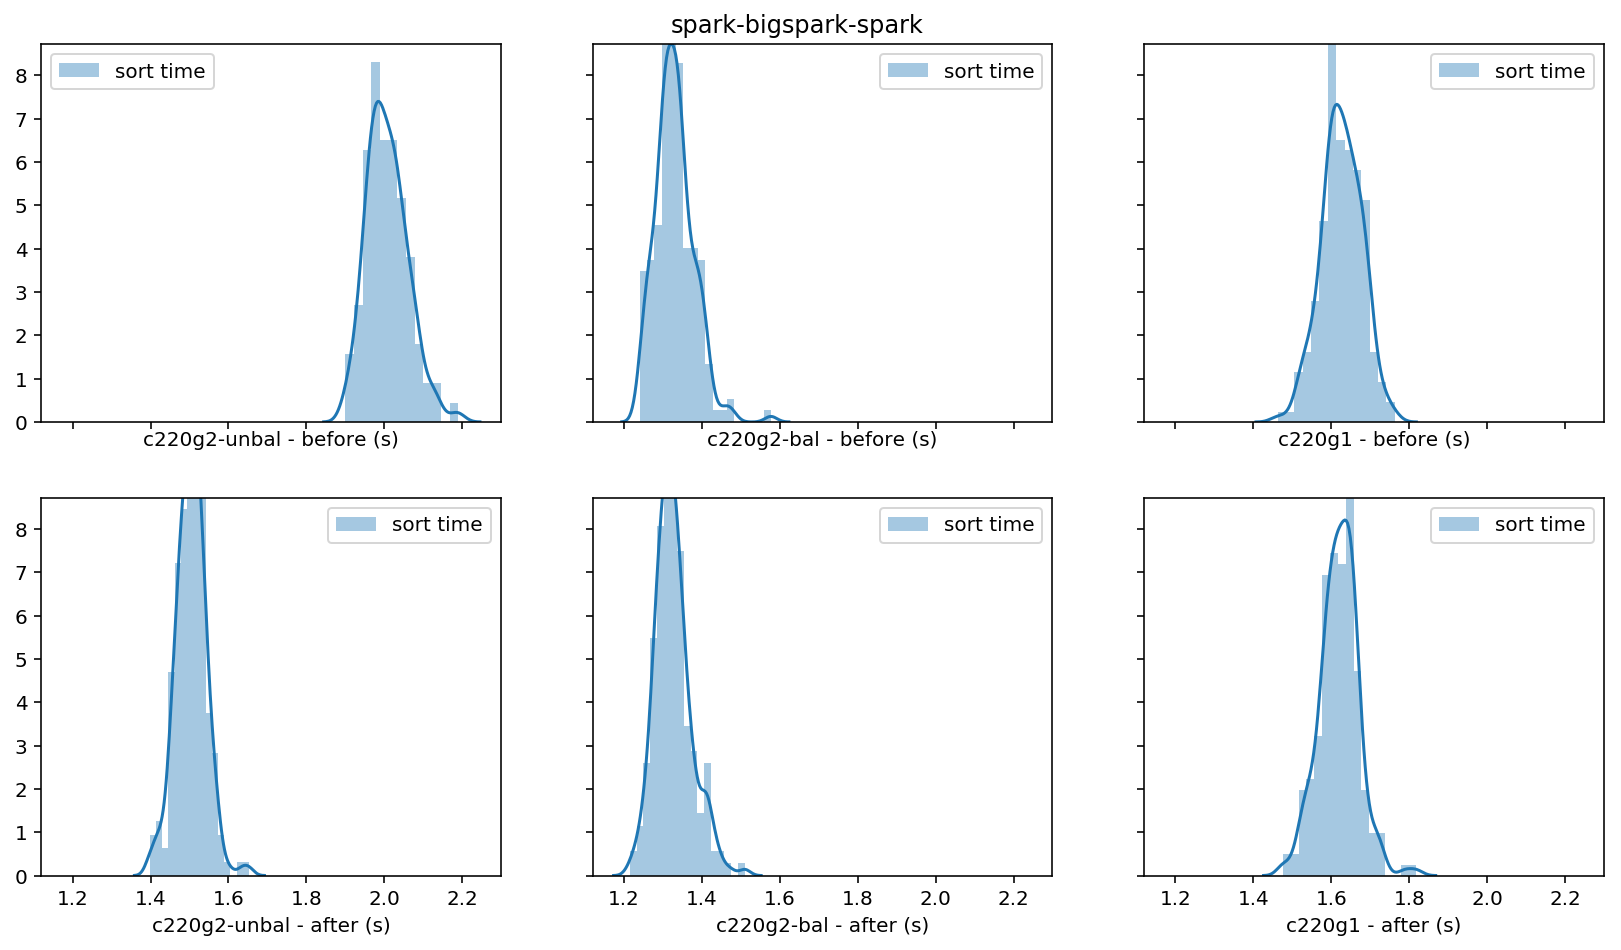

/notebooks/output/wisc-memtests/spark-bigspark-spark-histograms.pdf

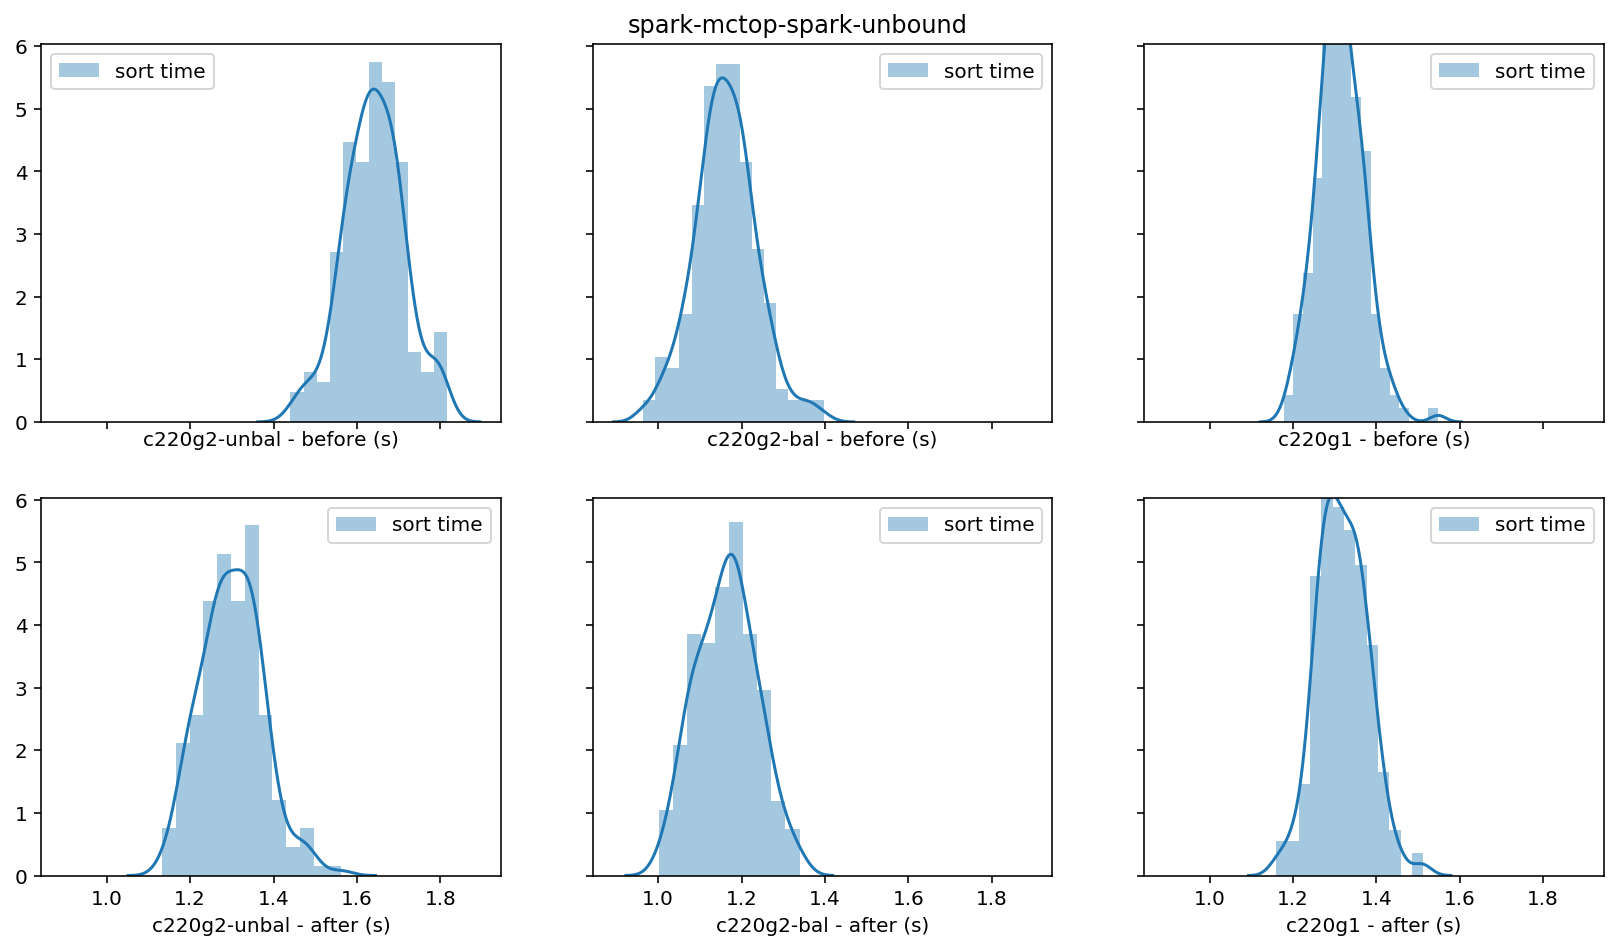

/notebooks/output/wisc-memtests/spark-mctop-spark-unbound-histograms.pdf

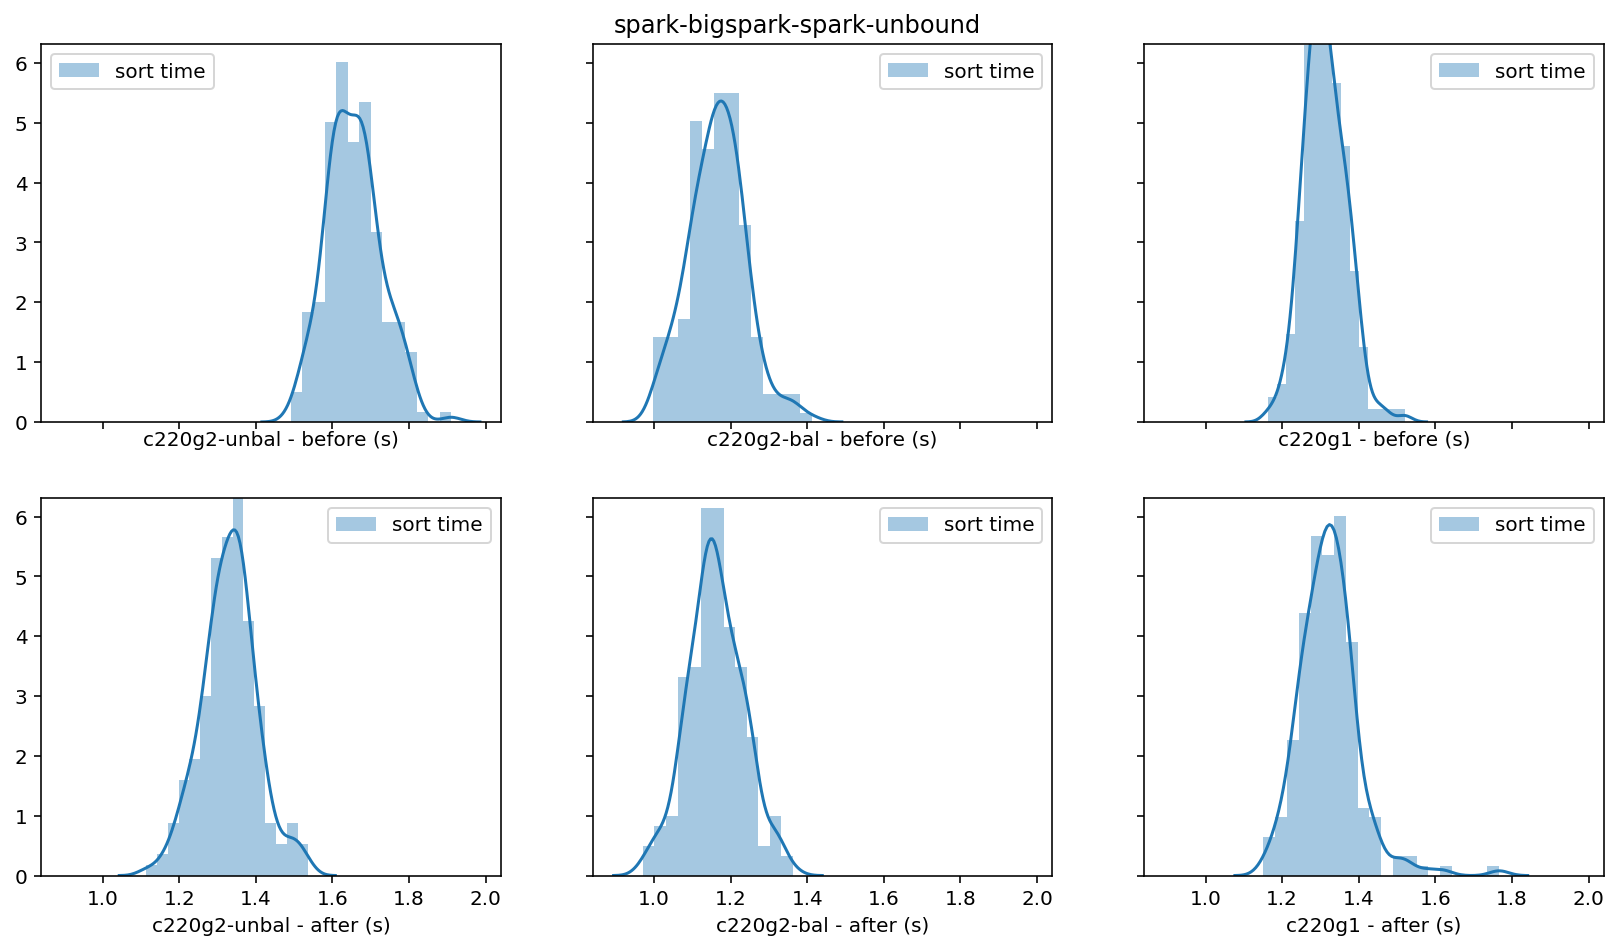

/notebooks/output/wisc-memtests/spark-bigspark-spark-unbound-histograms.pdf

In [10]:
# Min, Mean, and Max Histograms
for config in spark_db.keys():
    max_hw_types = len(spark_db[config]["hw_type"].unique())
    max_orders = len(spark_db[config]["order"].unique())
    f, axarr = plt.subplots(max_orders, max_hw_types, sharex=True, sharey=True, figsize=(14, 7))
    for order_idx, order in enumerate(orders):
        for hw_type_idx, hw_type in enumerate(spark_db[config]["hw_type"].unique()):
            plot_df = subset_df(spark_db[config], {"hw_type": hw_type, "order": order})
            sns.distplot(plot_df["time"], ax=axarr[order_idx, hw_type_idx], label="sort time")
            axarr[order_idx, hw_type_idx].set(xlabel=hw_type + ' - ' + order + ' (s)')
            axarr[order_idx, hw_type_idx].legend()
    f.suptitle(config)
    f.subplots_adjust(top=.95)
    dest = config + "-histograms.pdf"
    plot_show_and_save(f, dest, dest_dir)

## Pagemaps
### <font color='gray'> This is an attempt to use virtual->physical address mappings found in /proc/pid/pagemap to visualize what's changing in the memory management subsystem to cause the difference in performance.  So far, nothing conclusive has been drawn from this.</font>

In [11]:
source_dir = '/data/wisc-pagemaps'
dest_dir = "output/wisc-pagemaps"
pagemap_db = {}
for hw_type in os.listdir(source_dir):
    hw_type_path = os.path.join(source_dir, hw_type)
    pagemap_db[hw_type] = pd.DataFrame()
    for f in os.listdir(hw_type_path):
        file_path = os.path.join(hw_type_path, f)
        if 'stream' in f:
            order = f.split('_')[2]
        else:
            order = 'mctop'
        bench = f.split('_')[1]
        results_list = open(file_path).read().splitlines()
        results_tuple = [(float(x),hw_type,bench,order) for x in results_list]
        results_df = pd.DataFrame.from_records(results_tuple, columns = ['phys_addr', 'hw_type', 'benchmark', 'order'])
        pagemap_db[hw_type] = pd.concat([pagemap_db[hw_type], results_df])

if verbose:
    print "Keys: ", pagemap_db.keys()
    for k, df in pagemap_db.iteritems():
        print "Columns in %s:" % k, df.columns.tolist()
        print df["benchmark"].unique()
        display(df.sample(5))
        print "\n"

Keys:  ['c220g2-bal', 'c220g2-unbal', 'c220g1']
Columns in c220g2-bal: ['phys_addr', 'hw_type', 'benchmark', 'order']
['stream' 'mctop']


,phys_addr,hw_type,benchmark,order
7543393,13999711.0,c220g2-bal,mctop,mctop
1541660,7997978.0,c220g2-bal,mctop,mctop
9712375,16168693.0,c220g2-bal,mctop,mctop
18607920,31320733.0,c220g2-bal,mctop,mctop
3800875,10257193.0,c220g2-bal,mctop,mctop




Columns in c220g2-unbal: ['phys_addr', 'hw_type', 'benchmark', 'order']
['stream' 'mctop']


,phys_addr,hw_type,benchmark,order
3593693,14132175.0,c220g2-unbal,mctop,mctop
4587256,15125738.0,c220g2-unbal,mctop,mctop
17418918,38439609.0,c220g2-unbal,mctop,mctop
16688554,37707197.0,c220g2-unbal,mctop,mctop
2389054,12927536.0,c220g2-unbal,mctop,mctop




Columns in c220g1: ['phys_addr', 'hw_type', 'benchmark', 'order']
['stream' 'mctop']


,phys_addr,hw_type,benchmark,order
3350515,11885533.0,c220g1,mctop,mctop
5182823,13717841.0,c220g1,mctop,mctop
11884950,28822763.0,c220g1,mctop,mctop
4147251,12682269.0,c220g1,mctop,mctop
6300269,14835287.0,c220g1,mctop,mctop


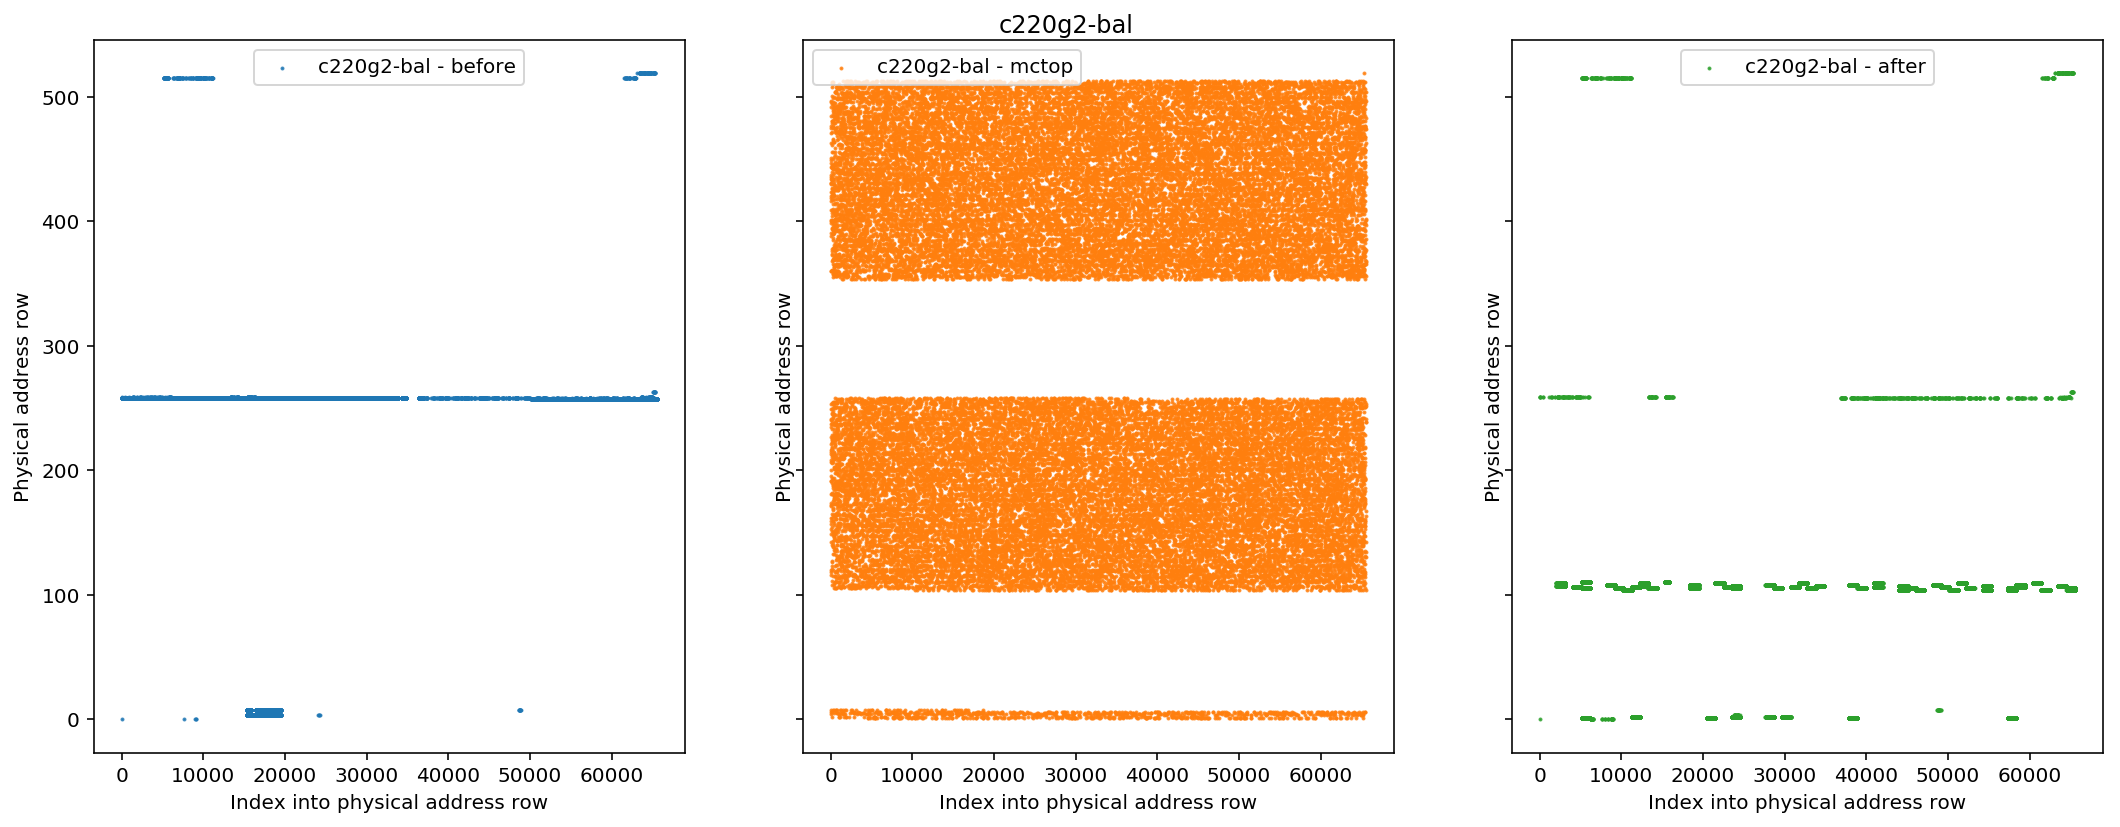

/notebooks/output/wisc-pagemaps/c220g2-bal-pagemap.pdf

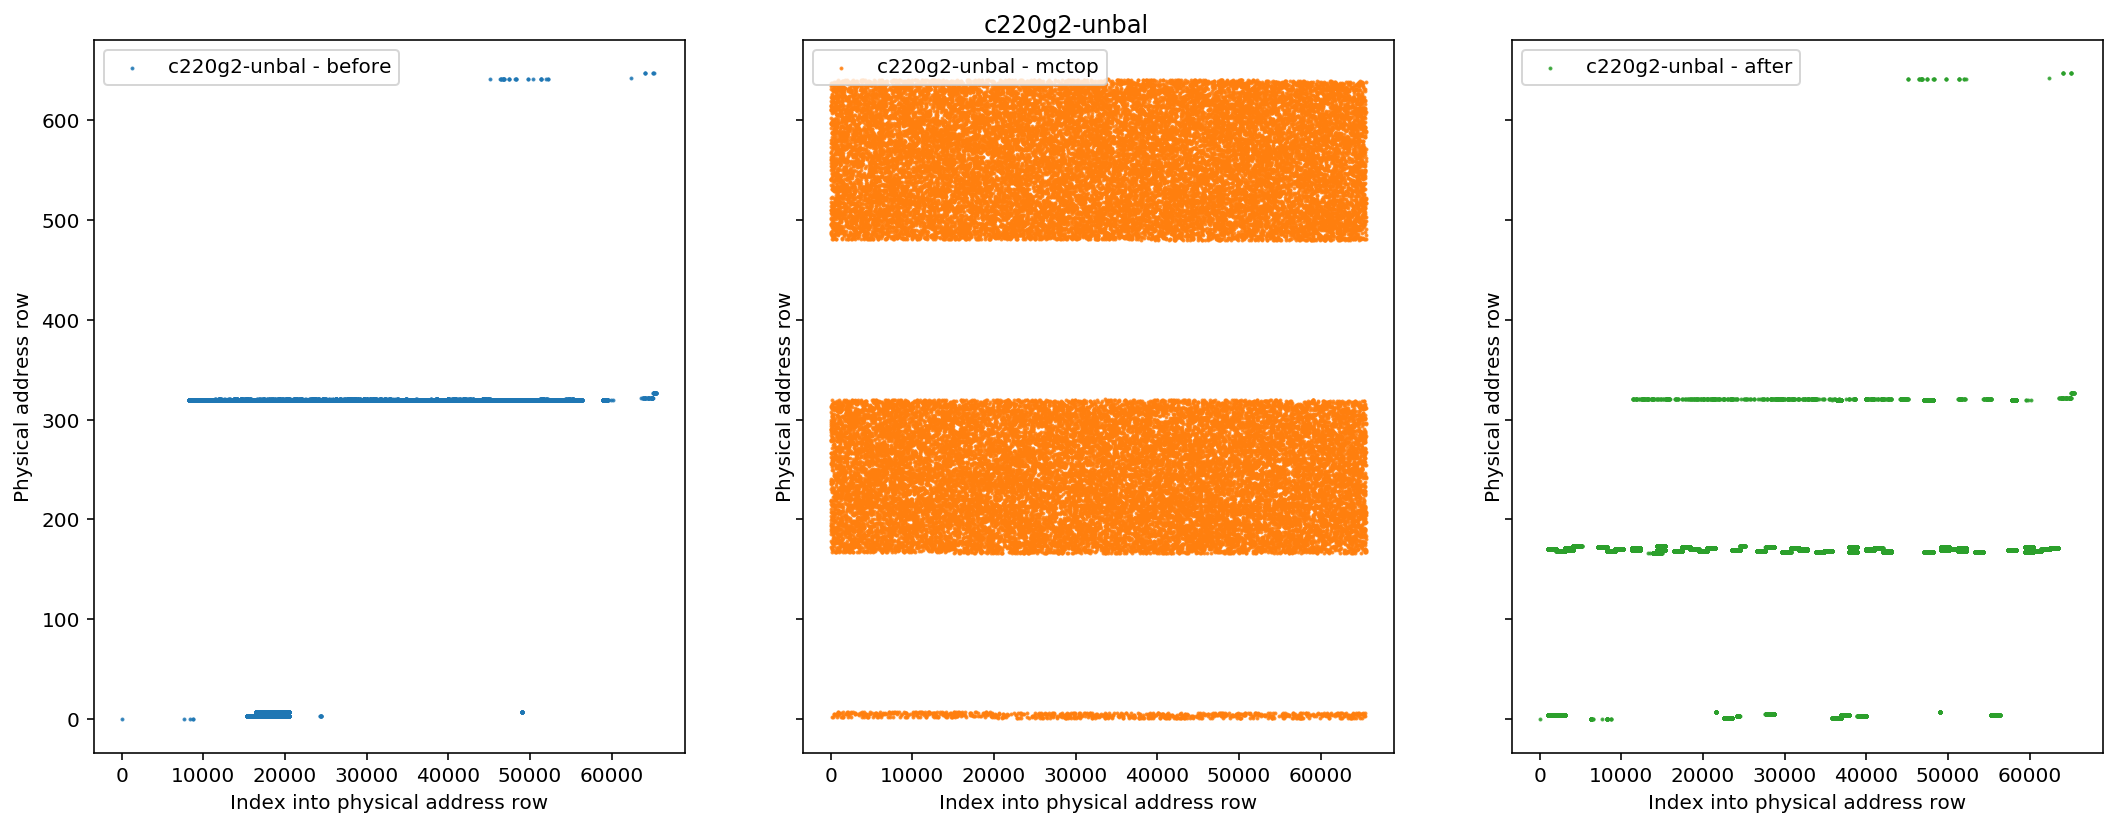

/notebooks/output/wisc-pagemaps/c220g2-unbal-pagemap.pdf

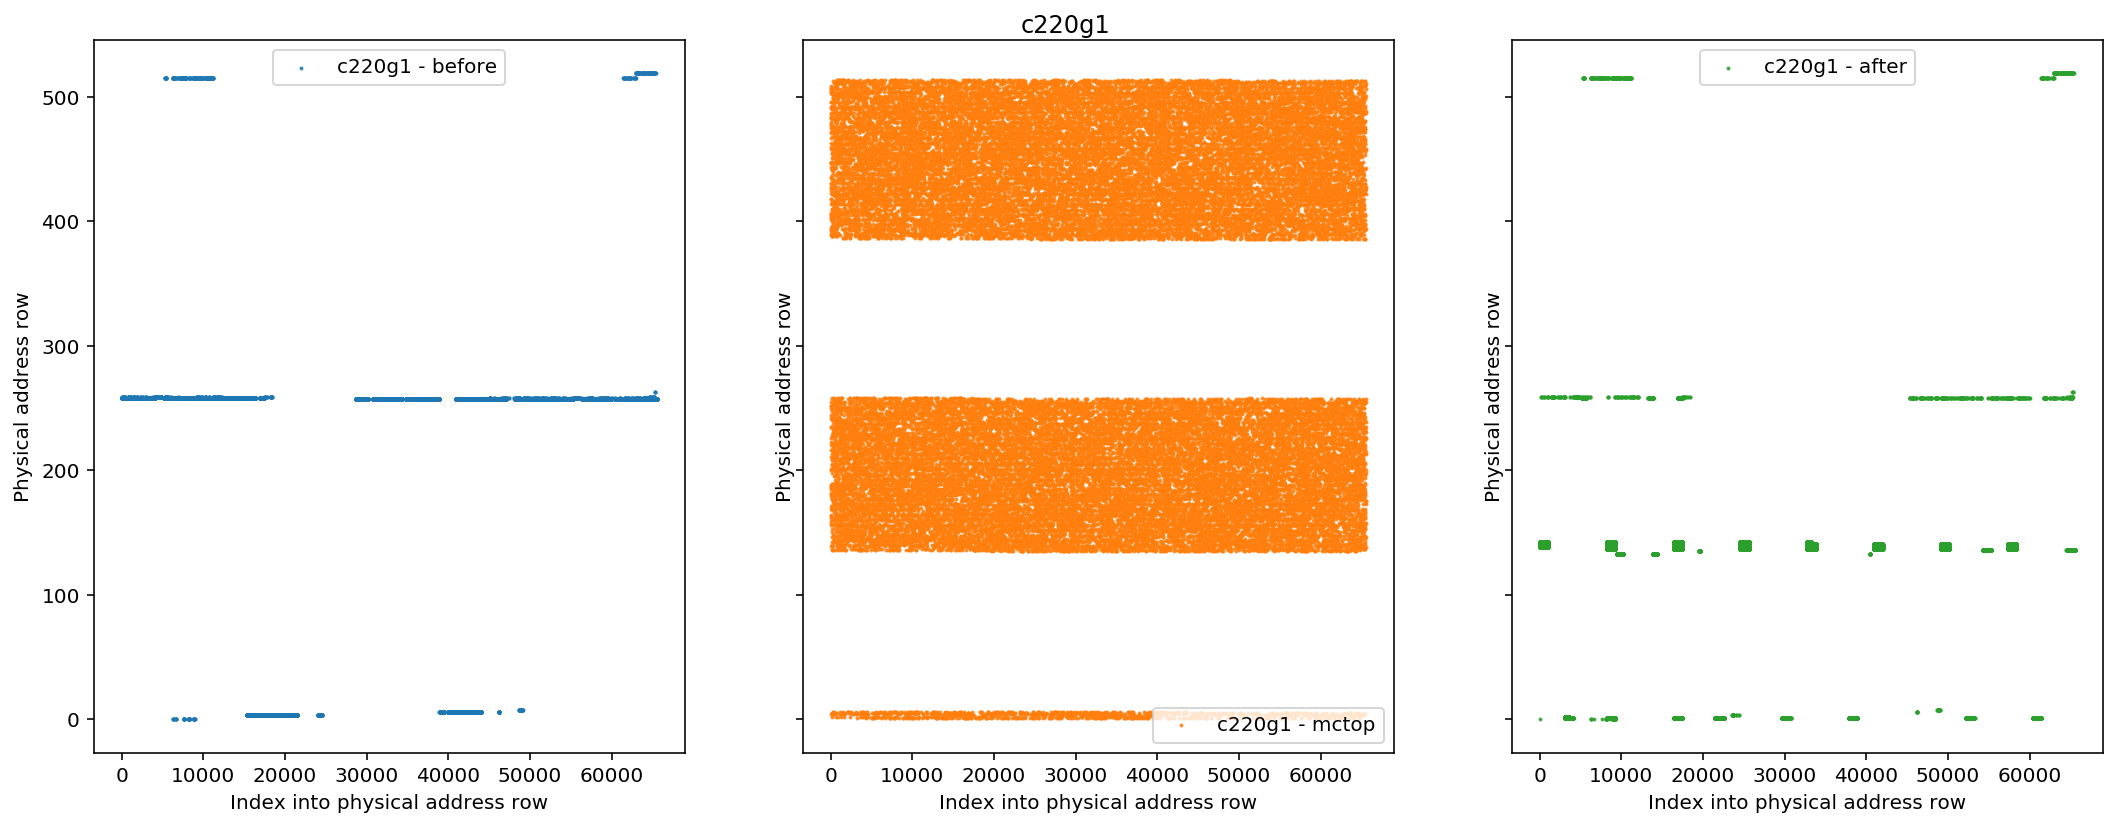

/notebooks/output/wisc-pagemaps/c220g1-pagemap.pdf

In [12]:
# Pagemap scatter plots
orders = ["before", "mctop", "after"]
mod = 65536
for hw_type in pagemap_db.keys():
    f, axarr = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6))
    for order_idx, order in enumerate(orders):
        plot_df = subset_df(pagemap_db[hw_type], {"hw_type": hw_type, "order": order})
        sample_df = plot_df.sample(50000)
        #sample_df = sample_df[sample_df.phys_addr < 22937600]
        sns.regplot(x=(sample_df["phys_addr"] % mod), y=np.floor(sample_df["phys_addr"]/mod), ax=axarr[order_idx], scatter_kws={'s':1}, fit_reg=False, label=hw_type + ' - ' + order)
        axarr[order_idx].set(xlabel='Index into physical address row')
        axarr[order_idx].set(ylabel='Physical address row')
        axarr[order_idx].legend()
    f.suptitle(hw_type)
    f.subplots_adjust(top=.95)
    dest = hw_type + "-pagemap.pdf"
    plot_show_and_save(f, dest, dest_dir)